In [67]:
import pandas as pd
import numpy as np
import scipy as sp
from prophet import Prophet
from sklearn.metrics import  mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from dateutil.relativedelta import relativedelta
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

# Preparing the Data

### Read Data

In [3]:
data_path = '../Data/Electric_Consumption.csv'
df=pd.read_csv(data_path)

print(df.shape)
df.head()

(521035, 27)


Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #  EDP  RC Code Funding Source  ... Meter Number Estimated  \
0  118.0  248  B011800        FEDERAL  ...      7223256         N   
1  118.0  248  B011800        FEDERAL  ...      7223256         N   
2  118.0  248  B011800        FEDERAL  ...      7223256         N   
3  118.0  248  B011800        FEDERAL  ...      7223256         N   
4  118.0  248  B011800        FEDERAL  ...      7223256         N   

   Current Charges   Rate Class Bill Analyzed Consumption (KWH)  KWH Charges  \
0         15396.82  GOV/NYC/068           Yes          128800.0      7387.97   
1         14556.34  GOV/NYC/068           Yes          115200.0      6607.87   
2         13904.98  GOV/NYC/068           Yes          103200.0      5919.55   
3         14764.04  GOV/NYC/068           Yes          105600.0      6057.22   
4         13729.54  GOV/NYC/068           Yes           97600.0      5598.34   

  Consumption (KW) KW Charges  Other charges  
0            216.0     2808.0        5200.85  
1            224.0     2912.0        5036.47  
2            216.0     2808.0        5177.43  
3            208.0     2704.0        6002.82  
4            216.0     2808.0        5323.20  

[5 rows x 27 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521035 entries, 0 to 521034
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    520414 non-null  object 
 1   Borough             521035 non-null  object 
 2   Account Name        521035 non-null  object 
 3   Location            507102 non-null  object 
 4   Meter AMR           520266 non-null  object 
 5   Meter Scope         27636 non-null   object 
 6   TDS #               519157 non-null  float64
 7   EDP                 521035 non-null  int64  
 8   RC Code             521035 non-null  object 
 9   Funding Source      521035 non-null  object 
 10  AMP #               518672 non-null  object 
 11  Vendor Name         521035 non-null  object 
 12  UMIS BILL ID        521035 non-null  int64  
 13  Revenue Month       521035 non-null  object 
 14  Service Start Date  521027 non-null  object 
 15  Service End Date    521027 non-nul

In [5]:
df['Service End Date'].nunique()

1053

In [6]:
df['Location'].nunique()

536

The data was collected seperatly by `location`. For completenece, we chose to aggregate the data using `mean()` over the 5 different Boroughs. Since the number of buildings (i.e, `location`) doesn't represent the entire NYC area.

In [7]:
# convert to datetime and rename columns
df['Service Start Date'] = pd.to_datetime(df['Service Start Date'])
df['ds'] = pd.to_datetime(df['Service End Date'])
df['y'] = df['Consumption (KWH)']

# set Date as index
df.set_index('ds', inplace=True)
df_ts = df[['y']].copy()

## Resampling - Monthly and Yearly

In [8]:
# resampling to monthly end date
df_monthly = df_ts.resample('ME').mean()
df_monthly = df_monthly[:-1] # remove last month (January 2025, which has no data)
df_monthly.index.freq = pd.infer_freq(df_monthly.index)
df_monthly = df_monthly.reset_index()
df_monthly.head()

ds             y
0 2010-01-31  45446.030782
1 2010-02-28  38824.279283
2 2010-03-31  36652.063380
3 2010-04-30  36823.726747
4 2010-05-31  36918.425453

In [9]:
# resampling to yearly end date
df_yearly = df_ts.resample('YE').mean()
df_yearly = df_yearly[:-1] # remove last month (2025, which has no data)
df_yearly.index.freq = pd.infer_freq(df_yearly.index)
df_yearly = df_yearly.reset_index()
df_yearly.head()

ds              y
0 2010-12-31   44608.503400
1 2011-12-31  150980.000000
2 2012-12-31   36346.207317
3 2013-12-31   32702.755515
4 2014-12-31   30694.267709

In [10]:
# save monthly and yearly data
df_monthly.to_csv('../Data/df_monthly.csv')
df_yearly.to_csv('../Data/df_yearly.csv')

# EDA

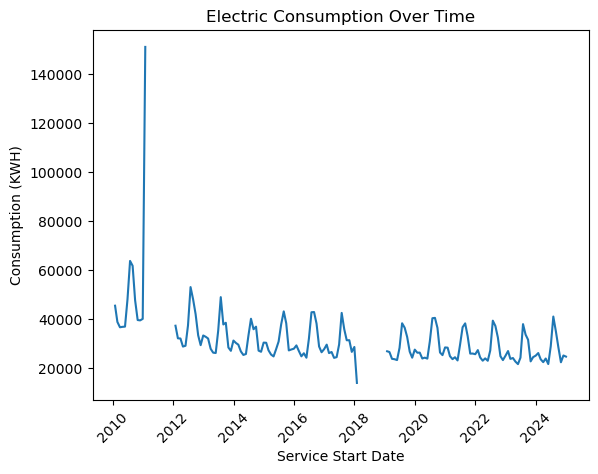

In [11]:
plt.ylabel('Consumption (KWH)')
plt.xlabel('Service Start Date')
plt.title('Electric Consumption Over Time')
plt.plot(df_monthly['ds'], df_monthly['y'])
plt.xticks(rotation=45)
plt.show()

In [12]:
#TODO: decomposing the time series
# def decompose_time_series(df):
#     result = seasonal_decompose(df, model='additive')
#     result.plot()
#     plt.show()

# # decompose_time_series(df_monthly)
# decompose_time_series(df_monthly)
# decompose_time_series(df_yearly)

In [13]:
#TODO: Seasoanl plot (from lectures)

# Prophet Predictions

In [14]:
def preprocess_and_split(df):
    """
    Preprocesses and splits the data into training and validation sets.
    This functon will be used for monthly dataset.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple: A tuple containing the training and validation DataFrames.
    """
    # convert date to datetime if needed
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)

    # drop rows with missing target values
    df = df.dropna(subset=['y'])

    # apply split
    train_df = df[(df['ds'] >= '2012-01-01') & (df['ds'] <= '2017-12-31')].copy()
    val_df = df[(df['ds'] >= '2019-01-01') & (df['ds'] <= '2024-12-31')].copy()

    return train_df, val_df


In [15]:
train_monthly_df, val_monthly_df = preprocess_and_split(df_monthly)

In [16]:
# # initialize and fit prophet model
# model = Prophet()
# model.fit(train_monthly_df)

# # forecast 9 months into the future
# future = model.make_future_dataframe(periods=9, freq='M')
# forecast = model.predict(future)

# # extract forecast points only

# # stitch last historical point to forecasted future for better visualization
# last_hist_point = train_monthly_df[['ds', 'y']].iloc[-1]
# last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
# forecast_future = forecast[forecast['ds'] > train_monthly_df['ds'].max()].reset_index(drop=True)
# forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)

# # plot historical data
# plt.figure(figsize=(12, 6))
# plt.plot(train_monthly_df['ds'], train_monthly_df['y'], color='black', label='Historical')

# # plot stitched forecast in 3 colored segments
# plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], color='green', label='Forecast: 1 month')
# plt.plot(forecast_line['ds'].iloc[1:6], forecast_line['yhat'].iloc[1:6], color='orange', label='Forecast: 2–6 months')
# plt.plot(forecast_line['ds'].iloc[5:], forecast_line['yhat'].iloc[5:], color='red', label='Forecast: 7–9 months')

# # confidence interval
# plt.fill_between(forecast_future['ds'],
#                  forecast_future['yhat_lower'],
#                  forecast_future['yhat_upper'],
#                  color='gray', alpha=0.2, label='Confidence Interval')

# # aesthetics
# plt.title('Electricity Consumption Forecast (Monthly)')
# plt.xlabel('Date')
# plt.ylabel('Electric Consumption')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [17]:
# # define and fit the model
# model_yearly = Prophet(growth='linear')
# model_yearly.fit(df_yearly)

# # forecast 20 years into the future
# future_years = model_yearly.make_future_dataframe(periods=20, freq='Y')
# forecast_yearly = model_yearly.predict(future_years)

# # extract forecasted portion
# forecast_future = forecast_yearly[forecast_yearly['ds'] > df_yearly['ds'].max()].reset_index(drop=True)

# # stitch last historical point to forecast
# last_hist_point = df_yearly[['ds', 'y']].iloc[-1]
# last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
# forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)

# # plot historical data
# plt.figure(figsize=(12, 6))
# plt.plot(df_yearly['ds'], df_yearly['y'], color='black', label='Historical')

# # segment forecast line: 1, 2–10, 11–20 years
# plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], color='green', label='Forecast: 1 year')
# plt.plot(forecast_line['ds'].iloc[1:11], forecast_line['yhat'].iloc[1:11], color='orange', label='Forecast: 2–10 years')
# plt.plot(forecast_line['ds'].iloc[10:], forecast_line['yhat'].iloc[10:], color='red', label='Forecast: 11–20 years')

# # confidence interval
# plt.fill_between(forecast_future['ds'],
#                  forecast_future['yhat_lower'],
#                  forecast_future['yhat_upper'],
#                  color='gray', alpha=0.2, label='Confidence Interval')

# # aesthetics
# plt.title('Electricity Consumption Forecast (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('Electric Consumption')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [18]:
# def detect_time_frequency(df):
#     """
#     Detect whether the time series is monthly or yearly based on data frequency.
    
#     Args:
#         df (pd.DataFrame): Input dataframe with 'ds' column containing dates
        
#     Returns:
#         str: 'monthly' or 'yearly'
#     """
#     if df['ds'].dt.freq == 'ME':
#         return 'monthly'
#     elif df['ds'].dt.freq == 'YE-DEC':
#         return 'yearly'
#     else:
#         return '0'


# def train_prophet_model(df, frequency):
#     """
#     Train a Prophet model based on the detected frequency
    
#     Args:
#         df (pd.DataFrame): Training dataframe with 'ds' and 'y' columns
#         frequency (str): 'monthly' or 'yearly'
        
#     Returns:
#         Prophet: Fitted Prophet model
#     """
#     if frequency == 'yearly':
#         model = Prophet(growth='linear')
#     else:  # monthly
#         model = Prophet()
    
#     model.fit(df)
#     return model

# def make_forecast(model, df, frequency):
#     """
#     Generate forecast using the fitted model
    
#     Args:
#         model (Prophet): Fitted Prophet model
#         df (pd.DataFrame): Training dataframe with 'ds' and 'y' columns
#         frequency (str): 'monthly' or 'yearly'
        
#     Returns:
#         tuple: (forecast DataFrame, forecast_future DataFrame, forecast_line DataFrame)
#     """
#     # Set forecast periods and frequency
#     if frequency == 'monthly':
#         periods = 9
#         freq = 'M'
#     else:  # yearly
#         periods = 20
#         freq = 'Y'
    
#     # Create future dataframe and predict
#     future = model.make_future_dataframe(periods=periods, freq=freq)
#     forecast = model.predict(future)
    
#     # Extract forecasted portion
#     forecast_future = forecast[forecast['ds'] > df['ds'].max()].reset_index(drop=True)
    
#     # Stitch last historical point to forecast
#     last_hist_point = df[['ds', 'y']].iloc[-1]
#     last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
#     forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)
    
#     return forecast, forecast_future, forecast_line

# def plot_forecast(df, forecast_future, forecast_line, frequency):
#     """
#     Plot the historical data and forecast with confidence intervals
    
#     Args:
#         df (pd.DataFrame): Training dataframe with 'ds' and 'y' columns
#         forecast_future (pd.DataFrame): Future forecast points
#         forecast_line (pd.DataFrame): Stitched forecast line
#         frequency (str): 'monthly' or 'yearly'
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Plot historical data
#     plt.plot(df['ds'], df['y'], color='black', label='Historical')
    
#     # Plot forecast segments with different colors based on frequency
#     if frequency == 'monthly':
#         plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], 
#                  color='green', label='Forecast: 1 month')
#         plt.plot(forecast_line['ds'].iloc[1:6], forecast_line['yhat'].iloc[1:6], 
#                  color='orange', label='Forecast: 2–6 months')
#         plt.plot(forecast_line['ds'].iloc[5:], forecast_line['yhat'].iloc[5:], 
#                  color='red', label='Forecast: 7–9 months')
#         title = 'Electricity Consumption Forecast (Monthly)'
#     else:  # yearly
#         plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], 
#                  color='green', label='Forecast: 1 year')
#         plt.plot(forecast_line['ds'].iloc[1:11], forecast_line['yhat'].iloc[1:11], 
#                  color='orange', label='Forecast: 2–10 years')
#         plt.plot(forecast_line['ds'].iloc[10:], forecast_line['yhat'].iloc[10:], 
#                  color='red', label='Forecast: 11–20 years')
#         title = 'Electricity Consumption Forecast (Yearly)'
    
#     # Plot confidence interval
#     plt.fill_between(forecast_future['ds'],
#                      forecast_future['yhat_lower'],
#                      forecast_future['yhat_upper'],
#                      color='gray', alpha=0.2, label='Confidence Interval')
    
#     # Set plot aesthetics
#     plt.title(title)
#     plt.xlabel('Date' if frequency == 'monthly' else 'Year')
#     plt.ylabel('Electric Consumption')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def forecast_time_series(df):
#     """
#     Main function to handle time series forecasting.
#     Automatically detects frequency and applies appropriate forecasting.
    
#     Args:
#         df (pd.DataFrame): DataFrame with 'ds' (datetime) and 'y' (values) columns
#     """
#     # Ensure correct data types
#     df = df.copy()
#     if not pd.api.types.is_datetime64_any_dtype(df['ds']):
#         df['ds'] = pd.to_datetime(df['ds'])
    
#     # Detect frequency
#     frequency = detect_time_frequency(df)
#     print(f"Detected time series frequency: {frequency}")
    
#     # Train model
#     model = train_prophet_model(df, frequency)
    
#     # Generate forecast
#     forecast, forecast_future, forecast_line = make_forecast(model, df, frequency)
    
#     # Plot results
#     plot_forecast(df, forecast_future, forecast_line, frequency)
    
#     return {
#         'model': model,
#         'forecast': forecast,
#         'frequency': frequency
#     }


In [19]:
# result = forecast_time_series(df_yearly)

In [87]:
#  detect frequency
def check_frequency(df):
    if df['ds'].dt.freq == 'ME':
        return 'M'
    elif df['ds'].dt.freq == 'YE-DEC':
        return 'Y'
    else:
        return '0'

# get forecast horizon by freq
def get_forecast_horizon(freq):
    if freq == 'M':
        return [1, 6, 9]
    elif freq == 'Y':
        return [1, 10, 20]
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

# handle interpolation for yearly data
def interpolate_yearly_data(df):
    # Interpolate missing data for yearly frequency
    df = df.set_index('ds').resample('Y').mean()  # Ensure data is indexed by 'ds' (date)
    df['y'] = df['y'].interpolate(method='linear')  # Linear interpolation for missing values
    df = df.reset_index()  # Reset index after interpolation
    return df

# fit model and forecast
def fit_and_forecast(df, freq, periods, seasonality_params, **prophet_kwargs):
    if freq == 'Y':  # For yearly data, interpolate and train on full data
        df = interpolate_yearly_data(df)
        if seasonality_params:
            model = Prophet(yearly_seasonality=False)
            model.add_seasonality(name='custom', **seasonality_params)
        else:
            model = Prophet(**prophet_kwargs)
        model.fit(df)
        future = model.make_future_dataframe(periods=periods[-1], freq='Y')  # Forecasting yearly
    else:  # For monthly data, use the existing method
        print("monthly")
        if seasonality_params:
            model = Prophet(yearly_seasonality=False)
            model.add_seasonality(name='custom', **seasonality_params)
        else:
            model = Prophet(**prophet_kwargs)
        model.fit(df)
        future = model.make_future_dataframe(periods=periods[-1], freq=freq)  # Forecasting monthly
    
    if 'cap' in df.columns:
        future['cap'] = df['cap'].iloc[-1]
        
    forecast = model.predict(future)
    return forecast, model

# plot forecast with color segments
def plot_forecast(train_df, val_df, forecast_val, forecast_future, freq):

    # plot setup
    plt.figure(figsize=(14, 6))
    if freq == 'M':
        plt.plot(train_df['ds'], train_df['y'], color='black', label='Train (Actual)')
        plt.plot(val_df['ds'], val_df['y'], color='gray', label='Validation (Actual)', linestyle='dashed')

        # plot validation forecast if available and well-formed
        plt.plot(forecast_val['ds'], forecast_val['yhat'], color='blue', label='Validation Forecast')
        plt.fill_between(forecast_val['ds'],
                        forecast_val['yhat_lower'],
                        forecast_val['yhat_upper'],
                        color='blue', alpha=0.2, label='Validation CI')
    else:
        plt.plot(train_df['ds'], train_df['y'], color='black', label='Train (Actual)')
        plt.plot(forecast_val['ds'], forecast_val['yhat'], color='blue', label='Training Forecast')
        plt.fill_between(forecast_val['ds'],
                        forecast_val['yhat_lower'],
                        forecast_val['yhat_upper'],
                        color='blue', alpha=0.2, label='Training CI')

    
    # forecast line for future
    forecast_line = forecast_future[['ds', 'yhat']]

    # plot future forecast in segments
    if freq == 'M':
        slices = [2, 7, 10]
        labels = ['1 month', '2–6 months', '7–9 months']
    elif freq == 'Y':
        slices = [2, 11, 21]
        labels = ['1 year', '2–10 years', '11–20 years']
    else:
        raise ValueError("Unsupported frequency")

    colors = ['green', 'orange', 'red']
    for i in range(3):
        start = slices[i - 1] - 1 if i > 0 else 0
        end = slices[i]
        plt.plot(forecast_line['ds'].iloc[start:end],
                 forecast_line['yhat'].iloc[start:end],
                 color=colors[i], label=f'Future Forecast: {labels[i]}')

    # plot future confidence interval
    plt.fill_between(forecast_future['ds'],
                     forecast_future['yhat_lower'],
                     forecast_future['yhat_upper'],
                     color='gray', alpha=0.3, label='Future CI')

    # final plot settings
    plt.title('Electricity Consumption Forecast: Validation + Future')
    plt.xlabel('Date')
    plt.ylabel('Electric Consumption (EC)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# evaluate model
def evaluate_model(df, forecast):
    merged = pd.merge(df, forecast[['ds', 'yhat']], on='ds', how='left')
    merged = merged.dropna(subset=['yhat'])  # drop rows without prediction

    y_true = merged['y']
    y_pred = merged['yhat']

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"\nModel Evaluation:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2%}")

# combine forecast outputs
def combine_forecast_outputs(train_df, val_df, forecast_val, forecast_future):
    # mark source for context
    train_df = train_df.copy()
    val_df = val_df.copy()
    forecast_val = forecast_val.copy()
    forecast_future = forecast_future.copy()

    train_df['set'] = 'train_actual'
    val_df['set'] = 'validation_actual'
    forecast_val['set'] = 'validation_forecast'
    forecast_future['set'] = 'future_forecast'

    # align columns
    df_train = train_df[['ds', 'y', 'set']]
    df_val = val_df[['ds', 'y', 'set']]
    df_fval = forecast_val[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    df_ffut = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    df_fval['set'] = 'validation_forecast'
    df_ffut['set'] = 'future_forecast'

    df_fval = df_fval.rename(columns={'yhat': 'y', 'yhat_lower': 'lower', 'yhat_upper': 'upper'})
    df_ffut = df_ffut.rename(columns={'yhat': 'y', 'yhat_lower': 'lower', 'yhat_upper': 'upper'})

    # assign NaNs for missing cols
    df_train['lower'] = df_train['upper'] = None
    df_val['lower'] = df_val['upper'] = None

    # unify
    full_df = pd.concat([df_train, df_val, df_fval, df_ffut], ignore_index=True)
    return full_df.sort_values('ds').reset_index(drop=True)

# unified pipeline
def run_forecasting_pipeline(df, seasonlity_params={}, **prophet_kwargs):
    freq = check_frequency(df)
    # preprocess and split
    if freq == 'M':
        train_df, val_df = preprocess_and_split(df)
        print(f"Train range: {train_df['ds'].min().date()} -> {train_df['ds'].max().date()}")
        print(f"Validation range: {val_df['ds'].min().date()} -> {val_df['ds'].max().date()}")
    else:
        print(f"Train range: {df['ds'].min().date()} -> {df['ds'].max().date()}")

    # get forecast horizon
    periods = get_forecast_horizon(freq)

    # train model on training set only
    if freq == 'M':
        _, model = fit_and_forecast(train_df, freq, periods, seasonlity_params, **prophet_kwargs)
    else:
        _, model = fit_and_forecast(df, freq, periods, seasonlity_params, **prophet_kwargs)

    # predict on validation set range if available
    if freq == 'M':  # plot the validation set prediction
        future_val = val_df[['ds']].copy()
        if 'cap' in val_df.columns:
            future_val['cap'] = val_df['cap'].iloc[-1]
        forecast_val = model.predict(future_val)
        print("\nValidation Set Evaluation:")
        evaluate_model(val_df, forecast_val)
    else:
        past_val = df[['ds']].copy()
        if 'cap' in df.columns:
            past_val['cap'] = df['cap'].iloc[-1]
        forecast_val = model.predict(past_val)  # No validation forecast for yearly data
        print("\Training Set Evaluation:")
        evaluate_model(df, forecast_val)

    # retrain on full (train + validation) for future forecasting
    if freq == 'M':
        combined_df = pd.concat([train_df, val_df], ignore_index=True)
    else:
        combined_df = df

    final_model = Prophet(growth='linear')  # you can apply tuned params here
    final_model.fit(combined_df)

    # forecast into future from 2025 onward
    future_periods = periods[-1]  # longest horizon
    future_df = final_model.make_future_dataframe(periods=future_periods, freq=freq)
    forecast_future = final_model.predict(future_df)

    # extract only future portion
    if freq =='M':
        forecast_future = forecast_future[forecast_future['ds'] > val_df['ds'].max()].reset_index(drop=True)
    else:
        forecast_future = forecast_future[forecast_future['ds'] > df['ds'].max()].reset_index(drop=True)

    # print and plot final results
    print("\nFuture Forecast (from Jan 2025):")
    if freq == 'M':
        plot_forecast(train_df, val_df, forecast_val, forecast_future, freq)
    else:
        plot_forecast(df, None, forecast_val, forecast_future, freq)

    display(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    return final_model, forecast_future


In [ ]:
# # plotting predictions
# def plot_forecast(train, test, forecast):

#     test = test.reset_index()
#     test.rename(columns={'Date': 'ds', 'EC': 'y'}, inplace=True)

#     predictions = forecast[forecast['ds'] >= test['ds'].min()] #test+forecast

#     plt.figure(figsize=(12, 6))

#     plt.plot(train['ds'], train['y'], label='Training Set', color='blue')
#     plt.plot(test['ds'], test['y'], label='Testing Set (Validation)', color='green')
#     plt.plot(predictions['ds'], predictions['yhat'], label='Forecast', color='orange')
#     plt.fill_between(predictions['ds'],predictions['yhat_lower'],predictions['yhat_upper'],color='orange', alpha=0.3, label='Confidence Interval')

#     plt.title('Prophet Forecast for Electric Consumption')
#     plt.xlabel('Year')
#     plt.ylabel('Consumption (KWH)')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8486
MAE: 1622.10
MAPE: 5.91%


14:50:49 - cmdstanpy - INFO - Chain [1] start processing
14:50:49 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


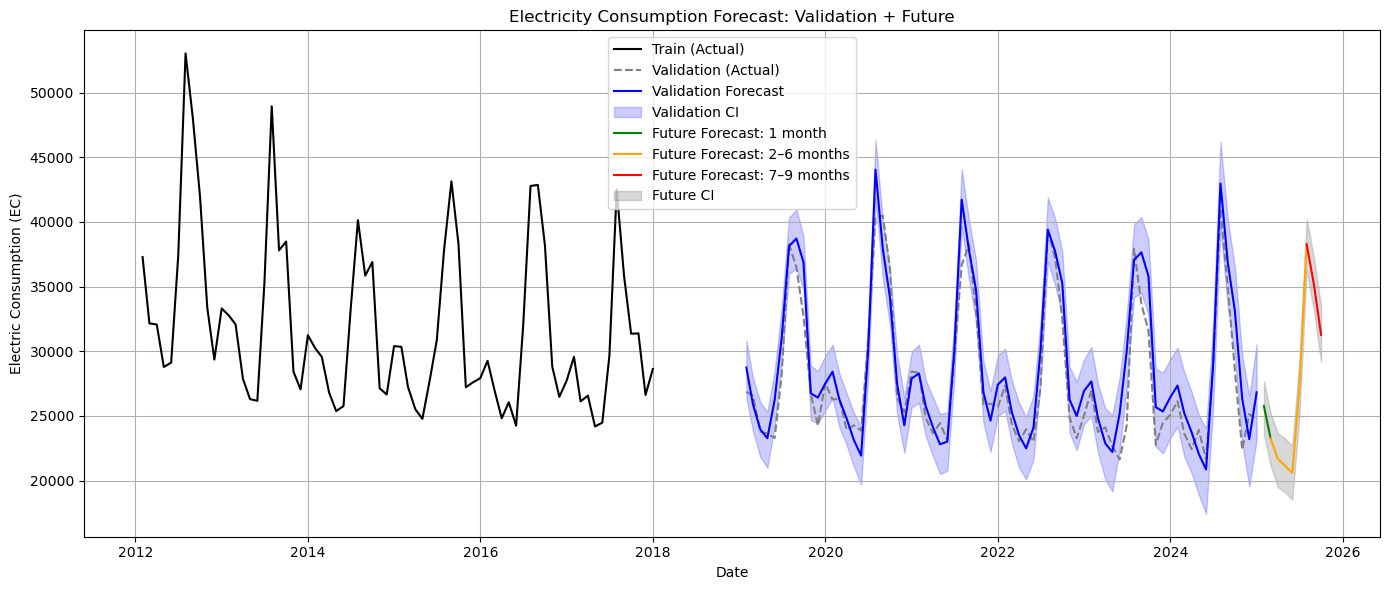

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23544.573097  27684.869552
1 2025-02-28  23273.640504  21168.154941  25243.975346
2 2025-03-31  21663.213247  19483.299442  23632.329102
3 2025-04-30  21151.120620  19105.103383  23268.798129
4 2025-05-31  20582.755317  18520.286712  22692.889617
5 2025-06-30  27111.668182  24910.973581  29264.057842
6 2025-07-31  38272.185382  36237.773066  40204.714564
7 2025-08-31  35130.123297  33103.321116  37226.284534
8 2025-09-30  31268.016773  29143.412205  33461.141612

Train range: 2010-12-31 -> 2024-12-31


14:50:51 - cmdstanpy - INFO - Chain [1] start processing
14:50:51 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16968.77
MAPE: 46.79%


14:50:52 - cmdstanpy - INFO - Chain [1] start processing
14:50:52 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


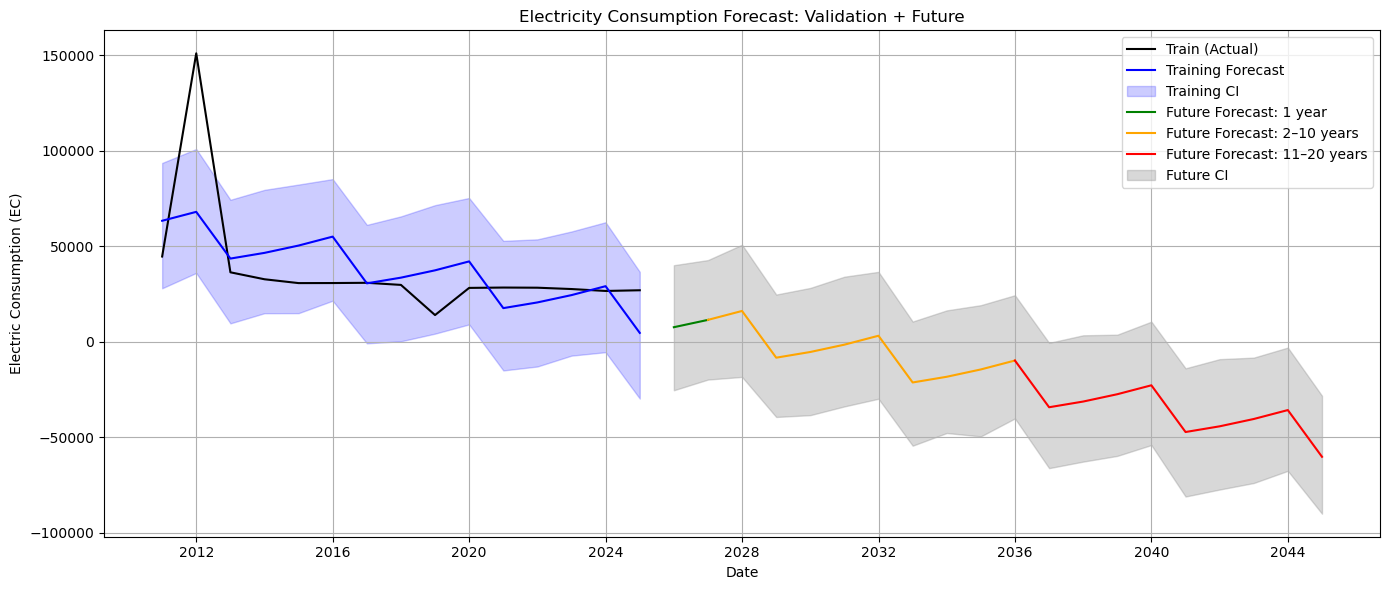

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -25415.736074  40062.455387
1  2026-12-31  11435.971813 -19815.879564  42744.181571
2  2027-12-31  16107.946362 -18419.953728  50790.794070
3  2028-12-31  -8352.617024 -39399.268565  24701.812129
4  2029-12-31  -5369.011127 -38441.527588  28163.645456
5  2030-12-31  -1536.945673 -33875.471735  34042.481077
6  2031-12-31   3135.028876 -29862.157352  36582.281406
7  2032-12-31 -21325.534510 -54435.302628  10568.889329
8  2033-12-31 -18341.928614 -47787.971403  16409.624539
9  2034-12-31 -14509.863160 -49560.586391  19136.893842
10 2035-12-31  -9837.888610 -40159.041499  24350.152123
11 2036-12-31 -34298.451997 -66188.139685   -595.590928
12 2037-12-31 -31314.846100 -62766.516835   3371.203123
13 2038-12-31 -27482.780646 -59781.200730   3690.182424
14 2039-12-31 -22810.806097 -54089.315771  10502.061343
15 2040-12-31 -47271.369483 -81047.923251 -13915.251525
16 2041-12-31 -44287.763586 -77386.554069  -9120.992548
17 2042-12-31 -40455.698132 -73975.670409  -8325.774822
18 2043-12-31 -35783.723583 -67604.447598  -3063.770248
19 2044-12-31 -60244.286969 -90036.722691 -28290.956702

In [62]:
# for monthly data
forecast_monthly, model_monthly = run_forecasting_pipeline(df_monthly)

# for yearly data
forecast_yearly, model_yearly = run_forecasting_pipeline(df_yearly)

# Optimization

## Monthly Optimization

### Growth

=============== logistic =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


14:37:58 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.3666
MAE: 3774.23
MAPE: 14.13%


14:38:00 - cmdstanpy - INFO - Chain [1] start processing
14:38:00 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


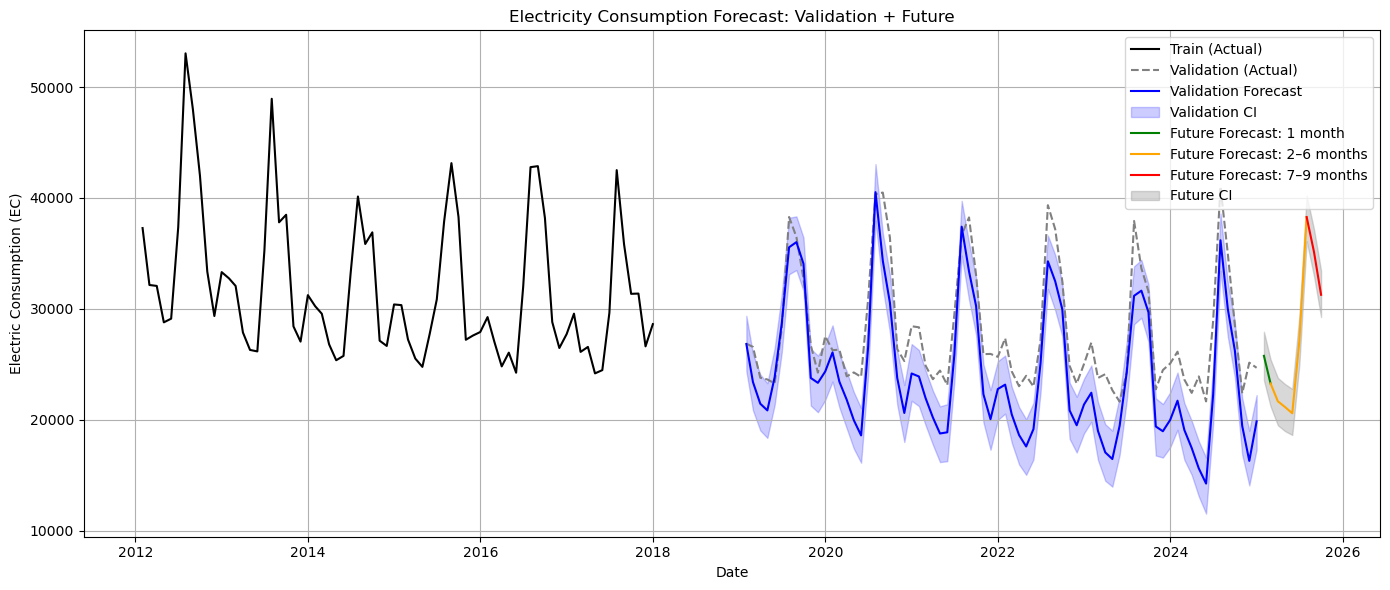

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23562.761027  27936.877754
1 2025-02-28  23273.640504  21210.381222  25440.813767
2 2025-03-31  21663.213247  19501.316066  23774.244223
3 2025-04-30  21151.120620  18979.543059  23222.737956
4 2025-05-31  20582.755317  18624.559096  22780.142982
5 2025-06-30  27111.668182  24979.308506  29318.908644
6 2025-07-31  38272.185382  36093.075964  40204.858438
7 2025-08-31  35130.123297  32965.263421  37183.855558
8 2025-09-30  31268.016773  29257.044371  33449.024264

=============== linear =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:03 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8486
MAE: 1622.10
MAPE: 5.91%


14:38:04 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


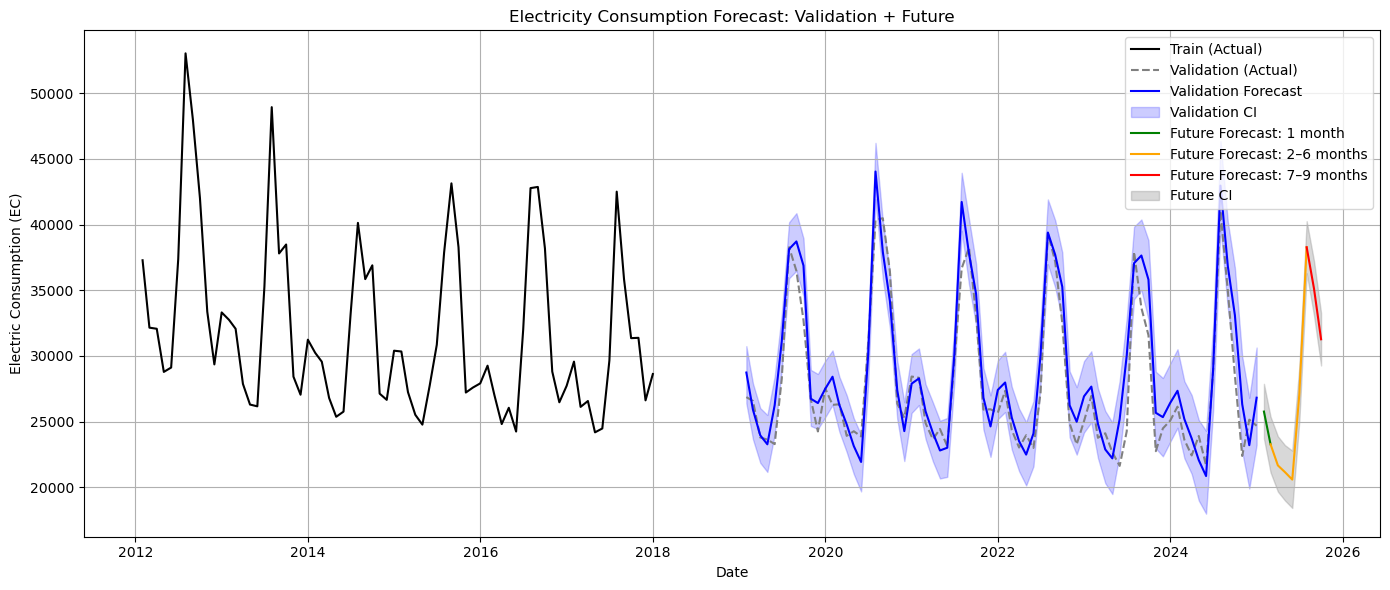

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23714.483229  27874.241366
1 2025-02-28  23273.640504  21138.558003  25373.411228
2 2025-03-31  21663.213247  19669.110534  23879.680205
3 2025-04-30  21151.120620  18992.776816  23205.210802
4 2025-05-31  20582.755317  18421.586553  22789.412096
5 2025-06-30  27111.668182  25062.587432  29176.200737
6 2025-07-31  38272.185382  36290.623538  40257.249250
7 2025-08-31  35130.123297  33098.542556  37239.745289
8 2025-09-30  31268.016773  29270.985730  33271.023773

=============== flat =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


14:38:06 - cmdstanpy - INFO - Chain [1] start processing
14:38:07 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.2991
MAE: 3999.09
MAPE: 14.84%


14:38:07 - cmdstanpy - INFO - Chain [1] start processing
14:38:07 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


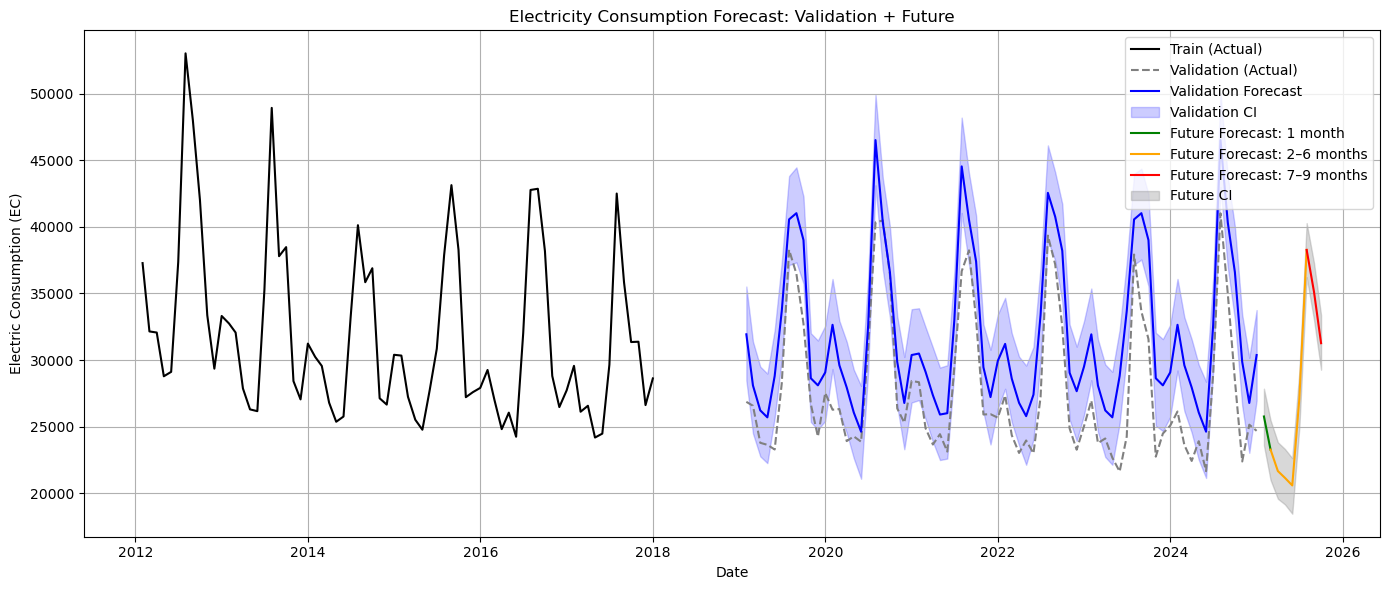

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23590.934030  27850.263679
1 2025-02-28  23273.640504  21000.051651  25477.548932
2 2025-03-31  21663.213247  19581.978953  23827.003643
3 2025-04-30  21151.120620  19156.947998  23319.695415
4 2025-05-31  20582.755317  18459.364887  22631.803972
5 2025-06-30  27111.668182  24942.717444  29102.950709
6 2025-07-31  38272.185382  36220.123445  40287.064797
7 2025-08-31  35130.123297  33043.112832  37304.401621
8 2025-09-30  31268.016773  29272.973187  33376.202178

In [51]:
growth_list = ['logistic', 'linear', 'flat']

for g in growth_list:
    
    prophet_params = {
        'growth': g,
    }

    if g == 'logistic':
        df_monthly_growth = df_monthly.copy()
        df_monthly_growth['cap'] = 55000
        # display(df_monthly_growth.head())

    else:
        df_monthly_growth = df_monthly.copy()
        
    print("===============", g, "=================")
    forecast_monthly, model_monthly = run_forecasting_pipeline(df_monthly_growth, **prophet_params)

#### Conclusion: `linear` growth has the best results out of `[logistic, linear, flat]`

### Seasonality

In [73]:
train_monthly_df, test_monthly_df = preprocess_and_split(df_monthly)

16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing


Period: 6, Fourier: 3, MAE: 4123.57


16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing


Period: 6, Fourier: 5, MAE: 4122.03


16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing


Period: 6, Fourier: 10, MAE: 4125.98


16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing


Period: 12, Fourier: 3, MAE: 4356.14


16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing


Period: 12, Fourier: 5, MAE: 4476.47


16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:15 - cmdstanpy - INFO - Chain [1] done processing


Period: 12, Fourier: 10, MAE: 4413.58

Best Parameters:
{'period': 6, 'fourier_order': 5}


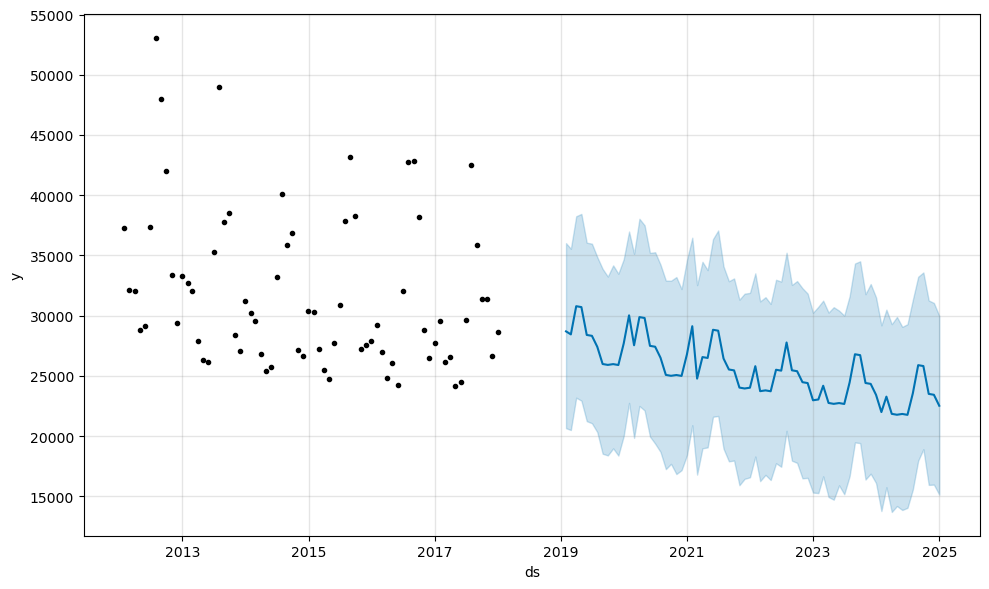

Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: -0.2417
MAE: 4122.03
MAPE: 13.18%


16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


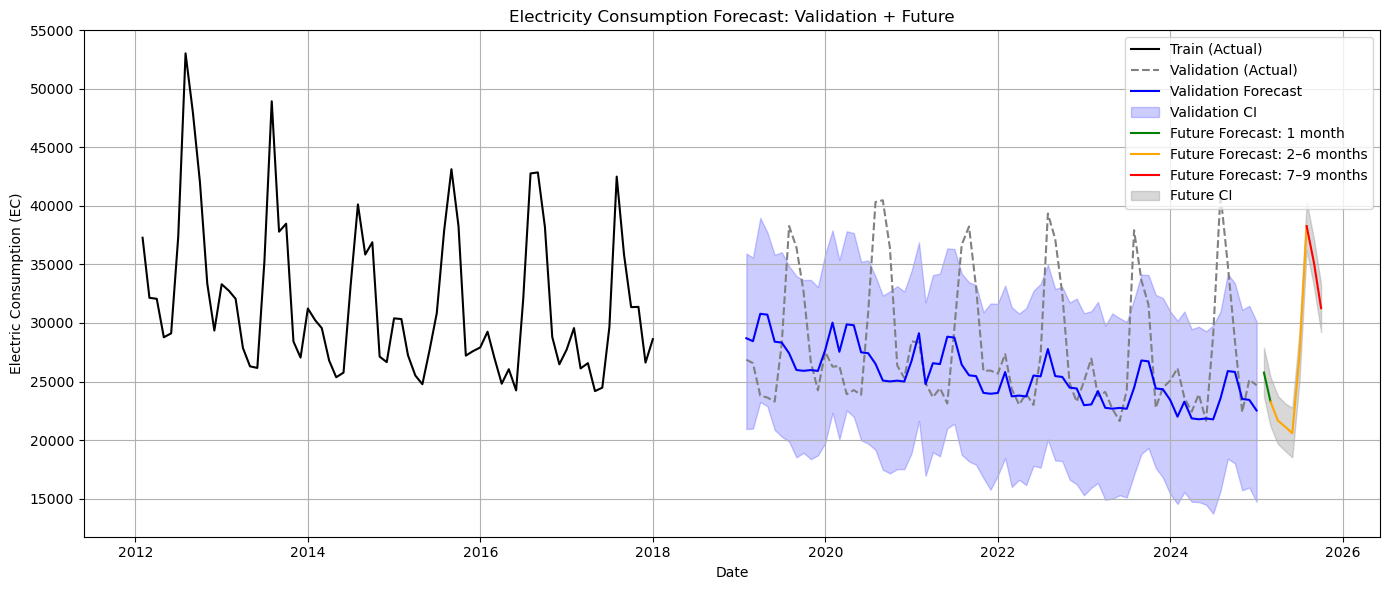

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23717.820572  27894.166861
1 2025-02-28  23273.640504  21181.769377  25372.903510
2 2025-03-31  21663.213247  19668.062220  23778.803100
3 2025-04-30  21151.120620  19091.136868  23147.404195
4 2025-05-31  20582.755317  18517.261851  22752.140298
5 2025-06-30  27111.668182  24893.769670  29120.456134
6 2025-07-31  38272.185382  36211.488314  40356.711488
7 2025-08-31  35130.123297  33088.440004  37158.991414
8 2025-09-30  31268.016773  29221.162536  33317.493299

In [ ]:
best_mae = float('inf')
best_params = {}
best_model = None
best_forecast = None

for period in [6, 12]:
    for fourier in [3, 5, 10]:
        model = Prophet(yearly_seasonality=False)
        model.add_seasonality(name='custom', period=period, fourier_order=fourier)
        model.fit(train_monthly_df)
        forecast = model.predict(test_monthly_df[['ds']])
        mae = mean_absolute_error(test_monthly_df['y'], forecast['yhat'])

        print(f"Period: {period}, Fourier: {fourier}, MAE: {mae:.2f}")
        if mae < best_mae:
            best_mae = mae
            best_params = {'period': period, 'fourier_order': fourier}
            best_model = model
            best_forecast = forecast

print("\nBest Parameters:")
print(best_params)

# best_model.plot(best_forecast)
# plt.show()

forecast_monthly, model_monthly = run_forecasting_pipeline(df_monthly, seasonality_params=best_params)


### Trend Changepoints

=============== 1 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


16:03:22 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.3796
MAE: 3731.71
MAPE: 13.97%


16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


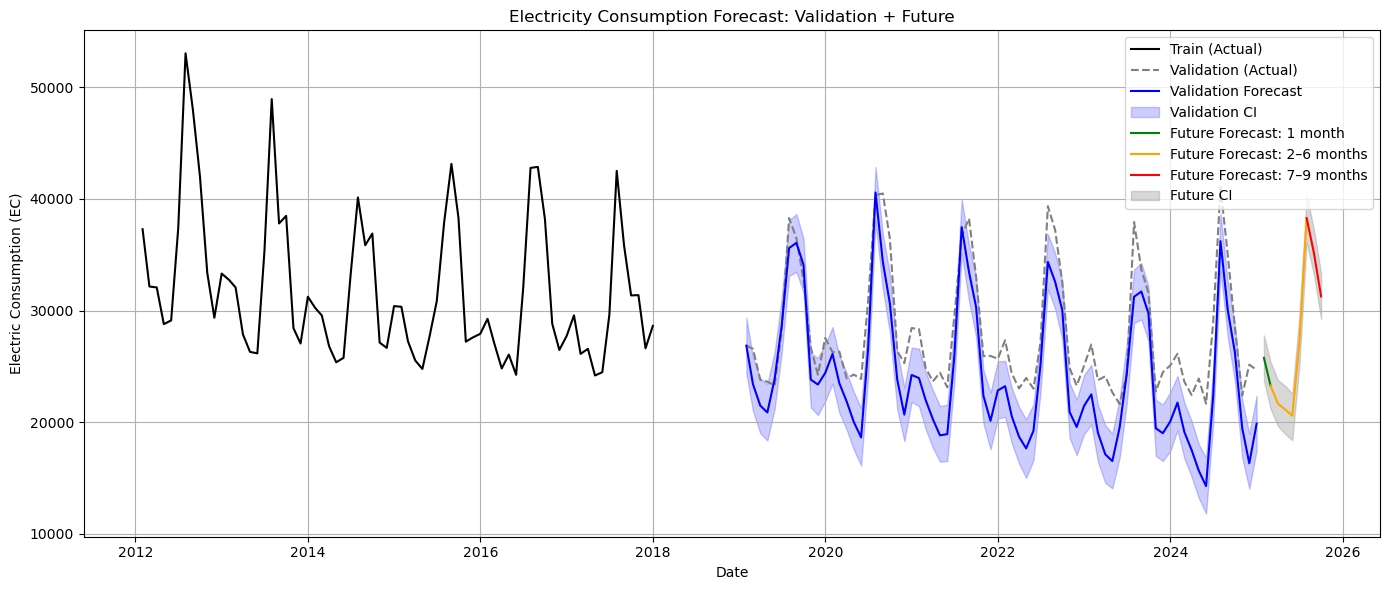

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23725.245959  27775.676439
1 2025-02-28  23273.640504  21204.507580  25394.527455
2 2025-03-31  21663.213247  19656.360030  23786.457303
3 2025-04-30  21151.120620  18951.581700  23282.117036
4 2025-05-31  20582.755317  18388.002653  22543.867408
5 2025-06-30  27111.668182  25041.241412  29459.347333
6 2025-07-31  38272.185382  36068.572739  40337.929512
7 2025-08-31  35130.123297  33176.489445  37216.254359
8 2025-09-30  31268.016773  29249.375722  33355.426279

=============== 6 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


16:03:25 - cmdstanpy - INFO - Chain [1] start processing
16:03:25 - cmdstanpy - INFO - Chain [1] done processing
16:03:26 - cmdstanpy - INFO - Chain [1] start processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8857
MAE: 1410.28
MAPE: 5.10%


16:03:26 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


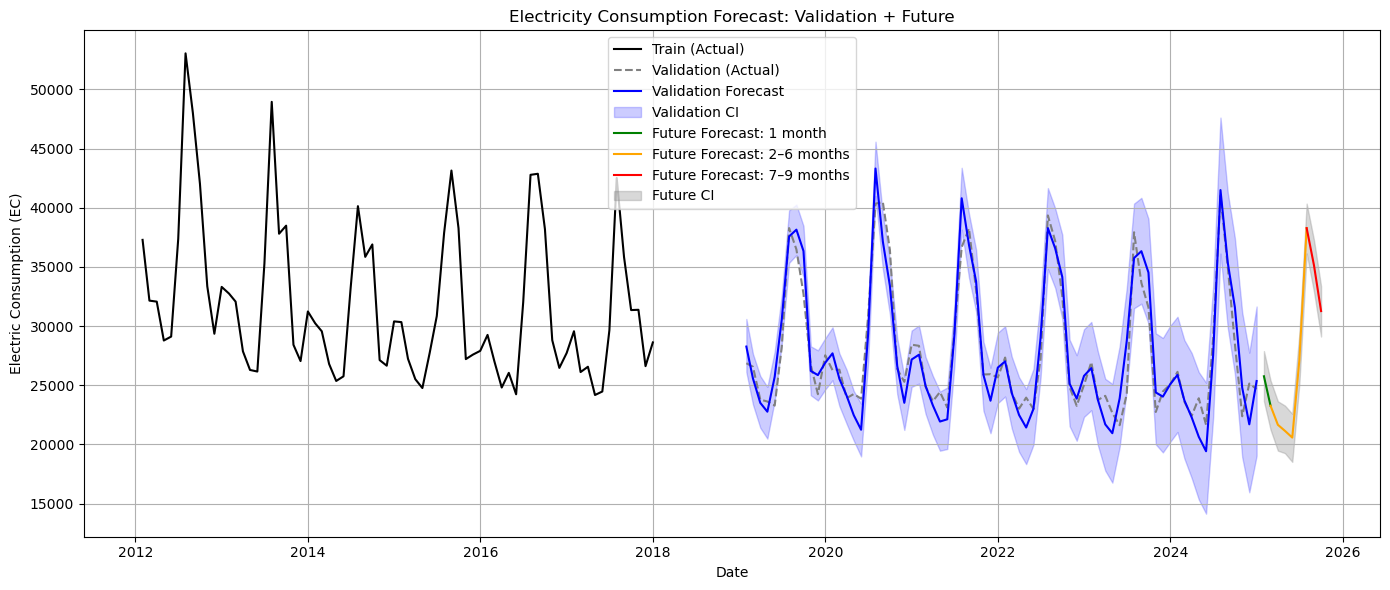

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23666.179606  27888.087367
1 2025-02-28  23273.640504  21258.985365  25403.391733
2 2025-03-31  21663.213247  19481.530325  23651.699978
3 2025-04-30  21151.120620  19267.110276  23282.541890
4 2025-05-31  20582.755317  18530.632181  22593.414037
5 2025-06-30  27111.668182  25114.156953  29324.883914
6 2025-07-31  38272.185382  36135.421094  40347.821569
7 2025-08-31  35130.123297  32907.885732  37263.554736
8 2025-09-30  31268.016773  29118.664114  33375.420692

=============== 12 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8852
MAE: 1412.74
MAPE: 5.10%


16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


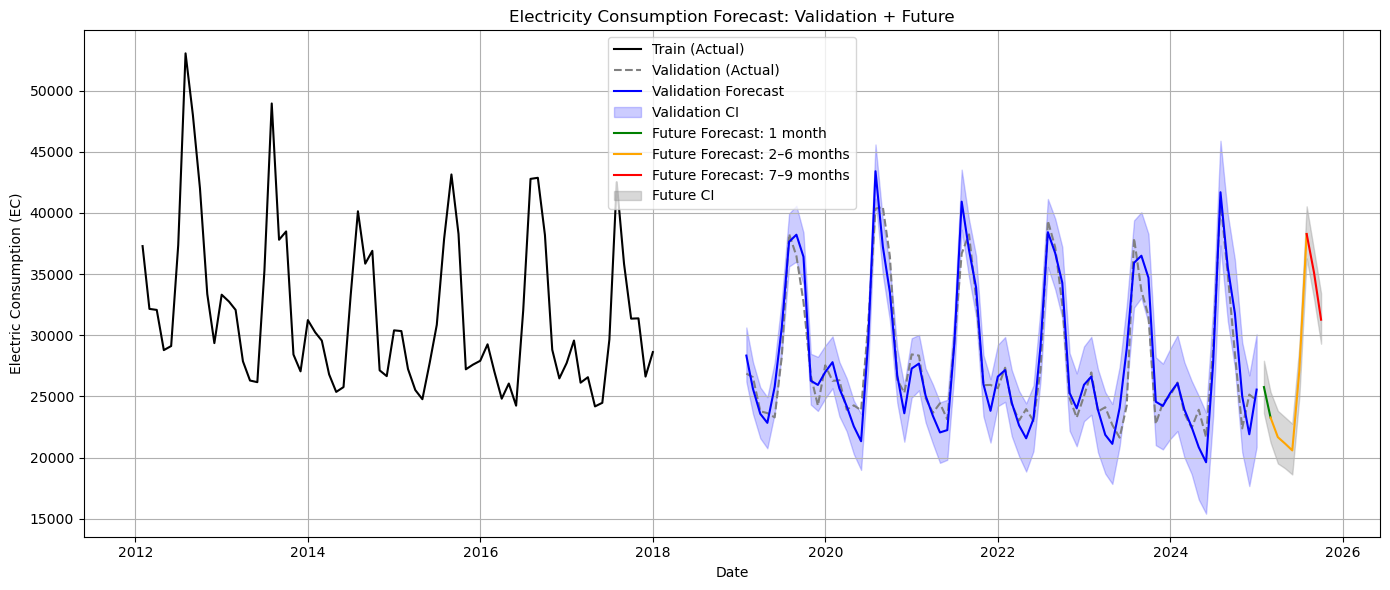

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23626.559592  27910.774575
1 2025-02-28  23273.640504  21242.441635  25362.443831
2 2025-03-31  21663.213247  19515.862055  23819.070285
3 2025-04-30  21151.120620  19125.951902  23303.093725
4 2025-05-31  20582.755317  18616.755043  22760.279568
5 2025-06-30  27111.668182  24960.715996  29099.159519
6 2025-07-31  38272.185382  36275.755784  40533.170126
7 2025-08-31  35130.123297  33007.959695  36963.398875
8 2025-09-30  31268.016773  29302.549682  33423.936847

=============== 25 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


16:03:29 - cmdstanpy - INFO - Chain [1] start processing
16:03:30 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8481
MAE: 1625.12
MAPE: 5.92%


16:03:31 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


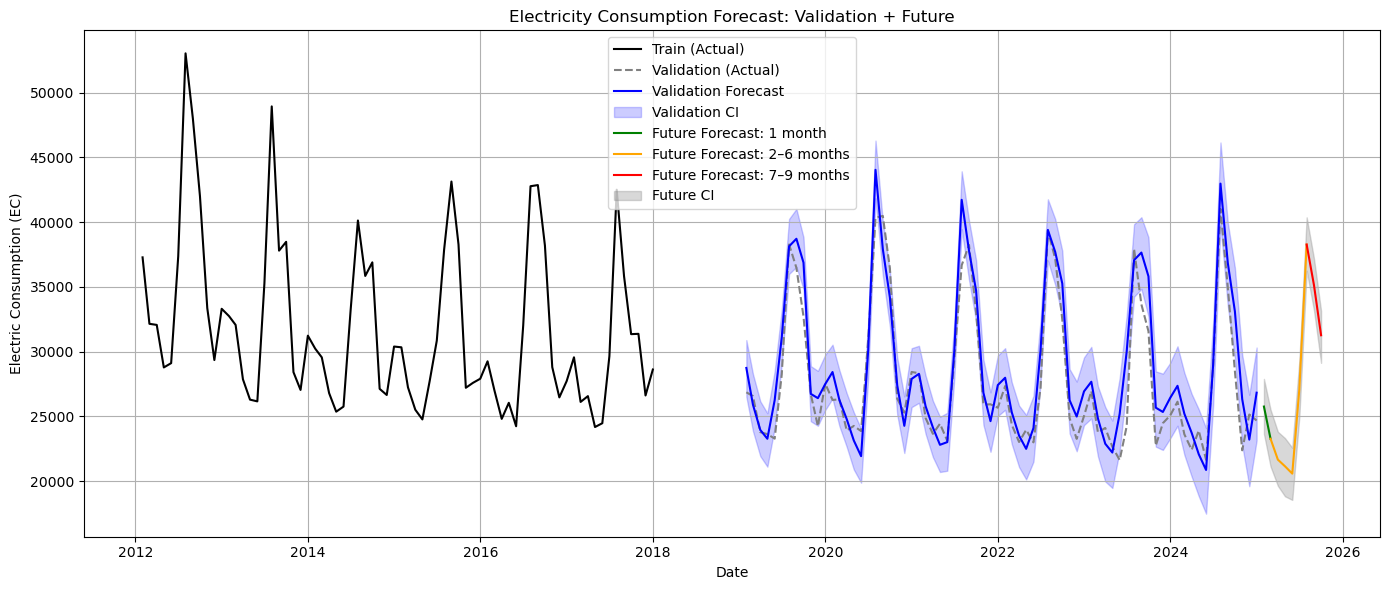

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23656.809991  27897.054781
1 2025-02-28  23273.640504  21138.877901  25524.643272
2 2025-03-31  21663.213247  19640.143232  23815.851617
3 2025-04-30  21151.120620  18834.377958  23327.020846
4 2025-05-31  20582.755317  18551.801630  22582.784144
5 2025-06-30  27111.668182  24974.721357  29290.704975
6 2025-07-31  38272.185382  36254.840282  40374.991491
7 2025-08-31  35130.123297  33197.788057  37184.878543
8 2025-09-30  31268.016773  29135.741526  33158.676634

In [72]:
# n_changepoints
n_changepoints = [1, 6, 12, 25]
prophet_params = {
    'changepoint_range': 1 # training set is spereated from validation set
}
for p in n_changepoints:
    print("===============", p, "=================")
    prophet_params['n_changepoints'] = p
    forecast_monthly, model_monthly = run_forecasting_pipeline(df_monthly, **prophet_params)

    # fig = model_monthly.plot(forecast_monthly)
    # a = add_changepoints_to_plot(fig.gca(), model_monthly, forecast_monthly)

=============== 0.05 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


15:24:42 - cmdstanpy - INFO - Chain [1] start processing
15:24:44 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8481
MAE: 1625.12
MAPE: 5.92%


15:24:45 - cmdstanpy - INFO - Chain [1] start processing
15:24:45 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


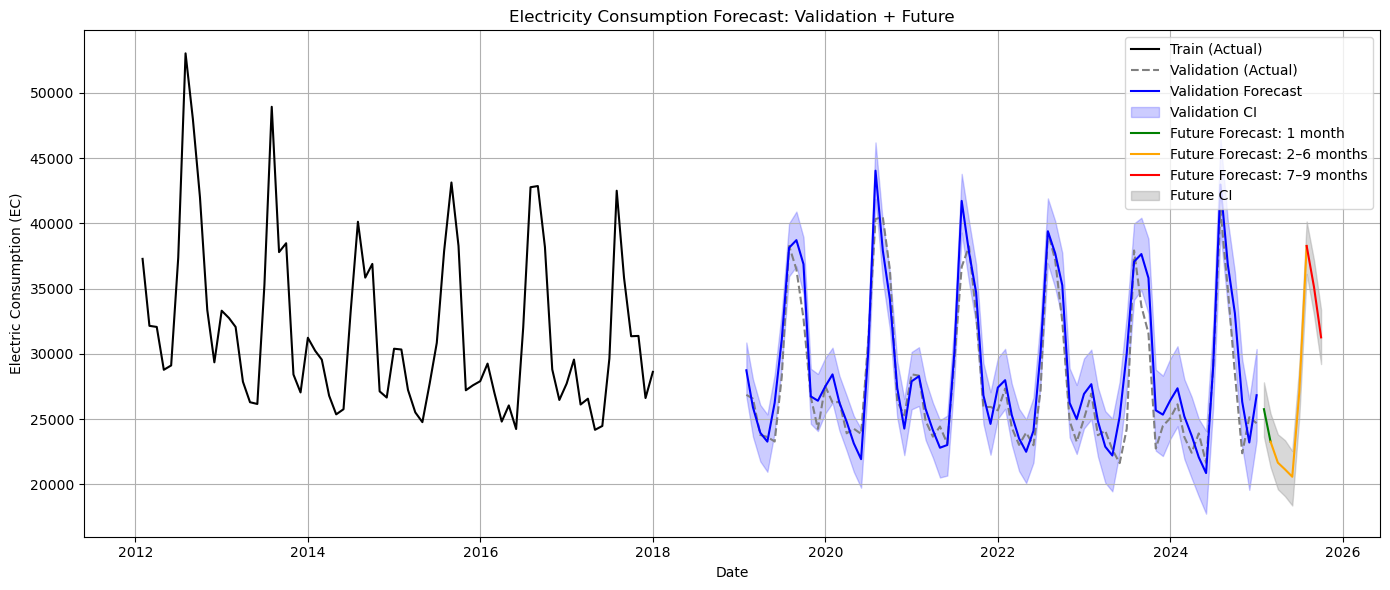

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23639.667707  27818.875179
1 2025-02-28  23273.640504  21324.644577  25424.814296
2 2025-03-31  21663.213247  19623.559778  23836.233790
3 2025-04-30  21151.120620  19094.812758  23385.713529
4 2025-05-31  20582.755317  18377.334141  22562.585657
5 2025-06-30  27111.668182  25231.741361  29150.822037
6 2025-07-31  38272.185382  36128.295371  40148.009370
7 2025-08-31  35130.123297  33007.221391  37196.581655
8 2025-09-30  31268.016773  29219.054926  33386.371979

=============== 0.01 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


15:24:47 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.3804
MAE: 3729.53
MAPE: 13.97%


15:24:48 - cmdstanpy - INFO - Chain [1] start processing
15:24:48 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


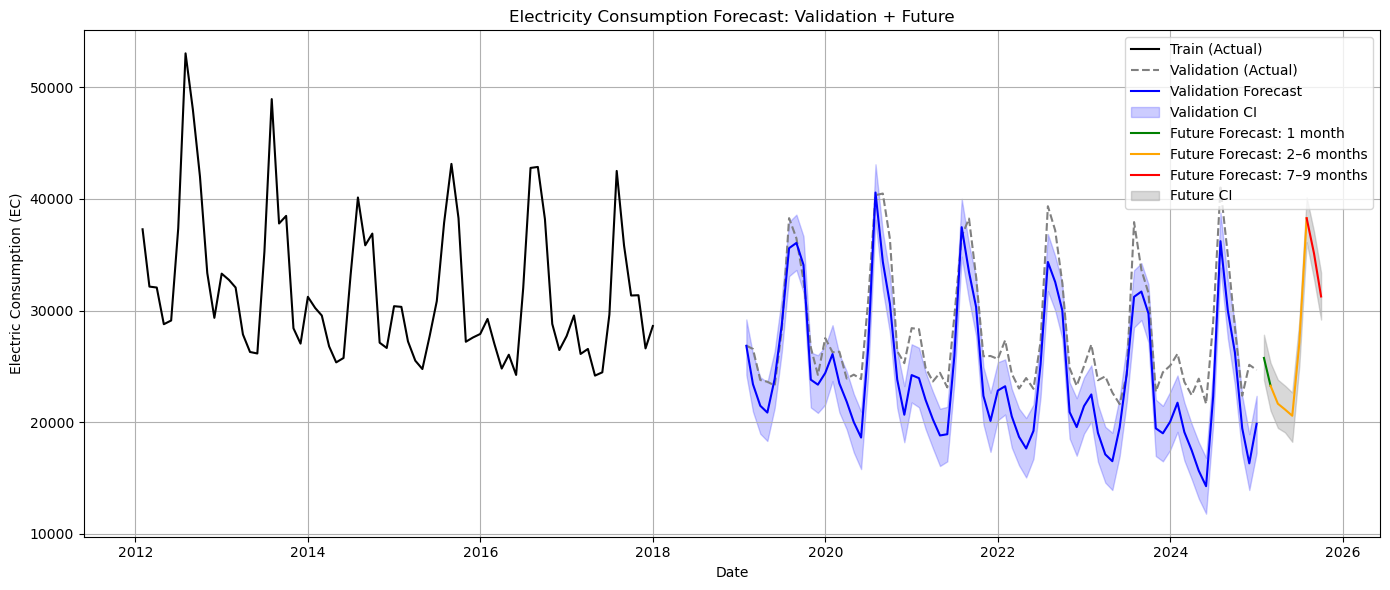

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23795.456103  27842.010876
1 2025-02-28  23273.640504  21053.294891  25324.183522
2 2025-03-31  21663.213247  19490.828310  23815.626925
3 2025-04-30  21151.120620  19096.970730  23284.383251
4 2025-05-31  20582.755317  18248.459232  22670.055471
5 2025-06-30  27111.668182  25082.257349  29079.028986
6 2025-07-31  38272.185382  36129.568227  40144.836041
7 2025-08-31  35130.123297  32848.136936  37097.864007
8 2025-09-30  31268.016773  29196.156239  33407.154887

=============== 0.025 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


15:24:49 - cmdstanpy - INFO - Chain [1] start processing
15:24:50 - cmdstanpy - INFO - Chain [1] done processing
15:24:50 - cmdstanpy - INFO - Chain [1] start processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8742
MAE: 1552.36
MAPE: 5.66%


15:24:50 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


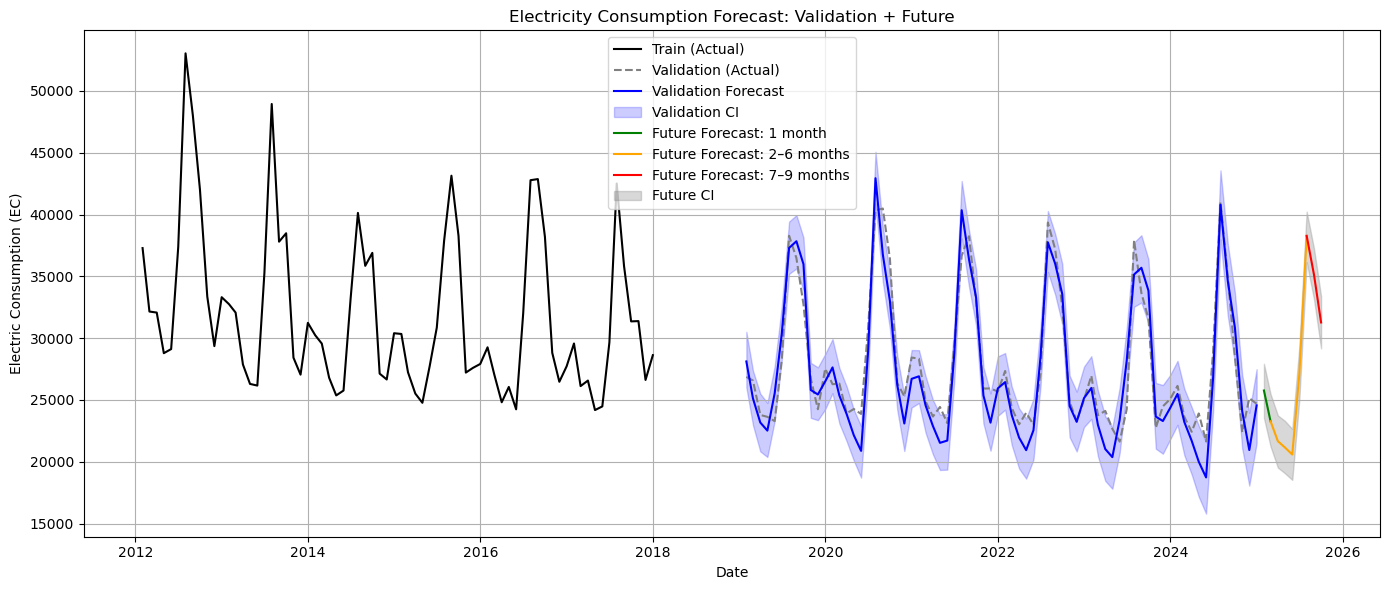

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23544.208470  27924.725967
1 2025-02-28  23273.640504  21242.138913  25477.034261
2 2025-03-31  21663.213247  19524.096902  23746.825182
3 2025-04-30  21151.120620  19067.299106  23305.900552
4 2025-05-31  20582.755317  18529.268416  22649.440498
5 2025-06-30  27111.668182  25038.546645  29323.100546
6 2025-07-31  38272.185382  36142.650065  40232.719076
7 2025-08-31  35130.123297  33154.517891  37248.095153
8 2025-09-30  31268.016773  29170.899520  33393.735569

=============== 0.075 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


15:24:52 - cmdstanpy - INFO - Chain [1] start processing
15:24:53 - cmdstanpy - INFO - Chain [1] done processing
15:24:53 - cmdstanpy - INFO - Chain [1] start processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8269
MAE: 1736.43
MAPE: 6.33%


15:24:53 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


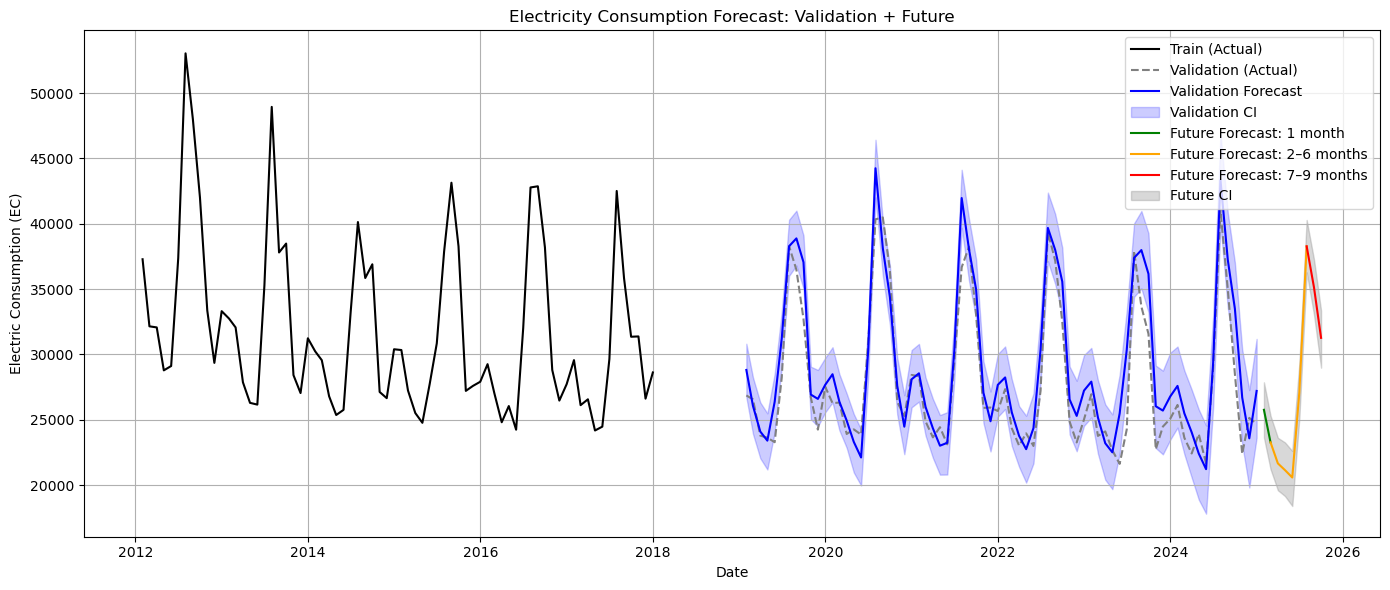

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23644.036210  27866.705892
1 2025-02-28  23273.640504  21224.233438  25306.345730
2 2025-03-31  21663.213247  19608.827279  23620.552451
3 2025-04-30  21151.120620  19166.462930  23269.565683
4 2025-05-31  20582.755317  18402.070660  22617.581253
5 2025-06-30  27111.668182  25119.634179  29301.200900
6 2025-07-31  38272.185382  36278.377282  40289.270634
7 2025-08-31  35130.123297  33054.801369  37270.996684
8 2025-09-30  31268.016773  28986.883528  33361.703016

=============== 0.1 =================
Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31
monthly


15:24:55 - cmdstanpy - INFO - Chain [1] start processing
15:24:55 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8273
MAE: 1733.74
MAPE: 6.32%


15:24:56 - cmdstanpy - INFO - Chain [1] start processing
15:24:56 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


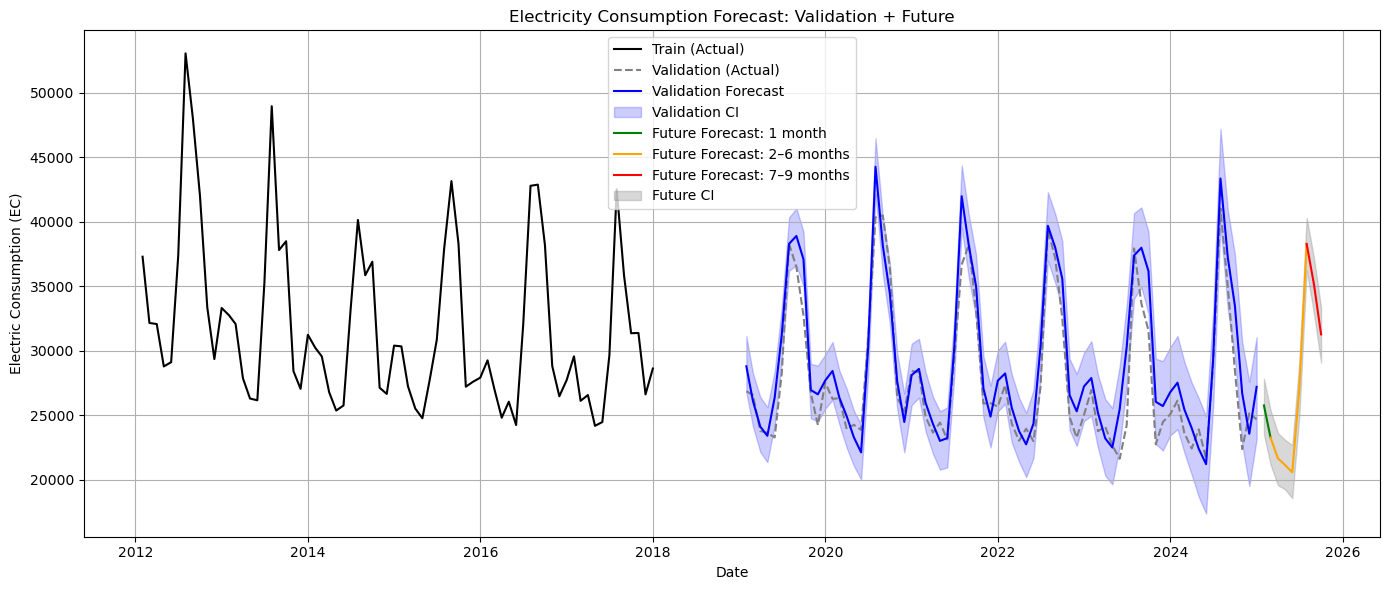

ds          yhat    yhat_lower    yhat_upper
0 2025-01-31  25761.985377  23507.320979  27845.540954
1 2025-02-28  23273.640504  21190.400553  25387.623928
2 2025-03-31  21663.213247  19588.158676  23631.788798
3 2025-04-30  21151.120620  19263.408189  23096.277689
4 2025-05-31  20582.755317  18571.292158  22691.310966
5 2025-06-30  27111.668182  25013.751876  29132.326387
6 2025-07-31  38272.185382  36222.776815  40294.696456
7 2025-08-31  35130.123297  32871.547696  37178.147741
8 2025-09-30  31268.016773  29077.269070  33330.904545

In [71]:
# changepoint_prior_scale
changepoint_prior_scale = [0.05, 0.01 ,0.025, 0.075, 0.1]
prophet_params = {
    'changepoint_range': 1 # training set is spereated from validation set
}
for p in changepoint_prior_scale:
    print("===============", p, "=================")
    prophet_params['changepoint_prior_scale'] = p
    forecast_monthly, model_monthly = run_forecasting_pipeline(df_monthly_growth, **prophet_params)

#### Conclustions:
1. We set `changepoint_range` to be 1 since the training set is seperated from the valdiation set.
1. The best `n_changepoint` from `[1, 6, 12, 25]` is 6. We chose these values after observing the peaks in the data.
2. the best `changepoint_prior_scale` from `[0.05, 0.01 ,0.025, 0.075, 0.1]` is 0.25.


## Yearly Optimization

### Growth

=============== logistic =================
Train range: 2010-12-31 -> 2024-12-31


14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3976
MAE: 15858.65
MAPE: 41.85%


14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


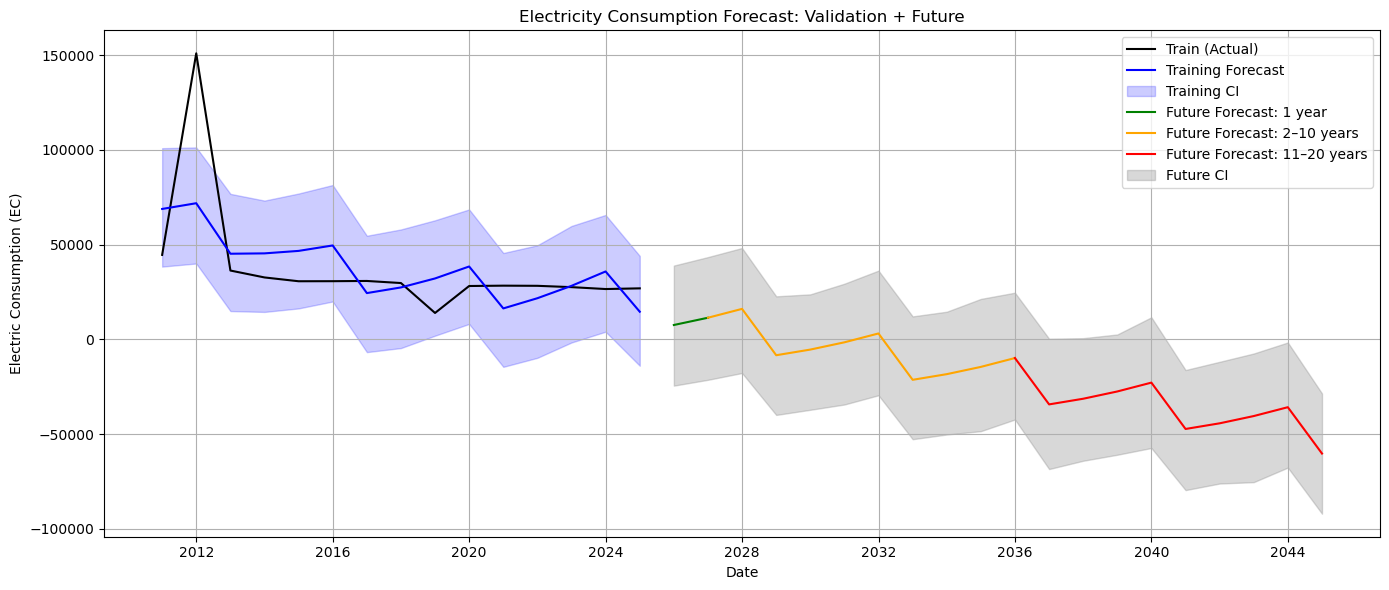

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -24405.375996  38969.015392
1  2026-12-31  11435.971813 -21332.731554  43448.887251
2  2027-12-31  16107.946362 -17743.259080  48232.882656
3  2028-12-31  -8352.617024 -39864.902587  22736.321414
4  2029-12-31  -5369.011127 -37155.250316  23779.093380
5  2030-12-31  -1536.945673 -34367.164012  29397.543544
6  2031-12-31   3135.028876 -29485.631248  36303.092350
7  2032-12-31 -21325.534510 -52677.033811  12143.130048
8  2033-12-31 -18341.928614 -50207.087024  14611.972591
9  2034-12-31 -14509.863160 -48431.910122  21368.540571
10 2035-12-31  -9837.888610 -42274.656257  24656.801820
11 2036-12-31 -34298.451997 -68429.623217    347.737564
12 2037-12-31 -31314.846100 -64052.929831    656.039714
13 2038-12-31 -27482.780646 -60883.952591   2602.407467
14 2039-12-31 -22810.806097 -57319.421266  11664.465592
15 2040-12-31 -47271.369483 -79540.546935 -16160.366559
16 2041-12-31 -44287.763586 -76074.148378 -11824.226613
17 2042-12-31 -40455.698132 -75339.640247  -7443.714556
18 2043-12-31 -35783.723583 -67648.043682  -1623.027646
19 2044-12-31 -60244.286969 -91995.393380 -28543.782749

=============== linear =================
Train range: 2010-12-31 -> 2024-12-31


14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing
14:45:28 - cmdstanpy - INFO - Chain [1] start processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16968.77
MAPE: 46.79%


14:45:28 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


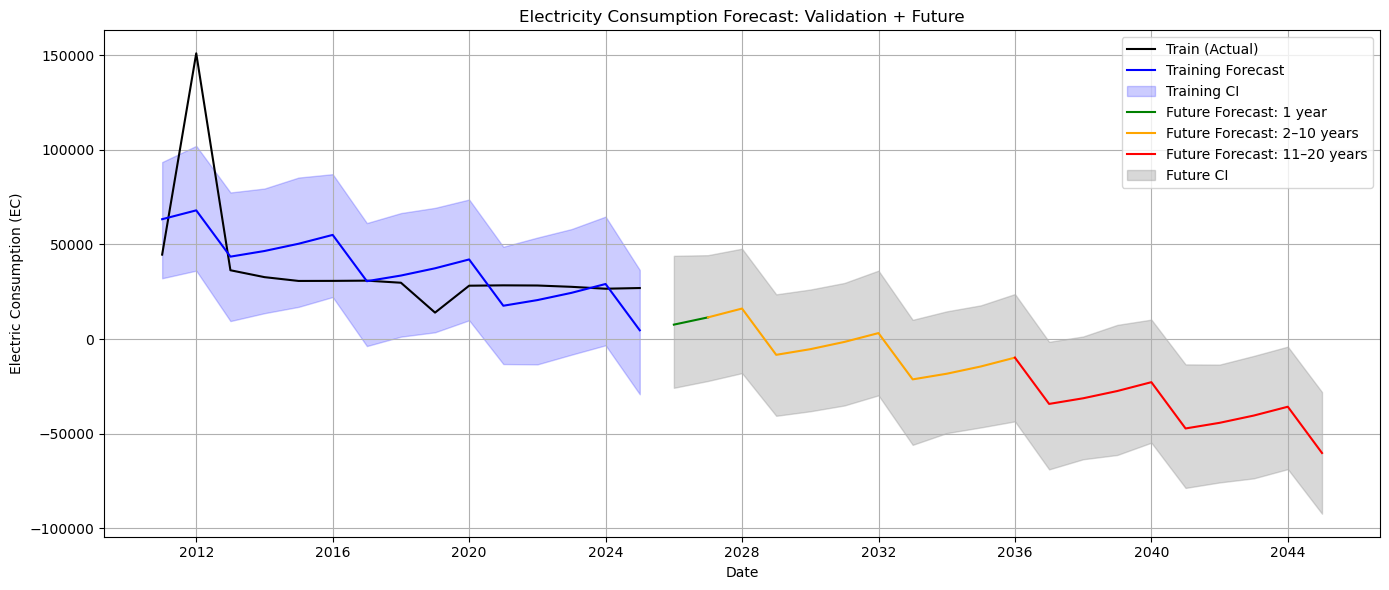

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -25787.193769  43971.246642
1  2026-12-31  11435.971813 -22187.106491  44311.581323
2  2027-12-31  16107.946362 -18024.706625  47737.905920
3  2028-12-31  -8352.617024 -40587.834278  23613.485879
4  2029-12-31  -5369.011127 -38189.845760  26145.654686
5  2030-12-31  -1536.945673 -35126.936034  29618.878203
6  2031-12-31   3135.028876 -29772.645608  36140.179111
7  2032-12-31 -21325.534510 -55936.671174  10137.383368
8  2033-12-31 -18341.928614 -49736.074512  14619.678600
9  2034-12-31 -14509.863160 -46733.805964  17794.151222
10 2035-12-31  -9837.888610 -43527.537785  23756.090724
11 2036-12-31 -34298.451997 -68896.844306  -1484.476057
12 2037-12-31 -31314.846100 -63550.112919   1343.557630
13 2038-12-31 -27482.780646 -61288.816302   7462.216466
14 2039-12-31 -22810.806097 -54797.690934  10253.522454
15 2040-12-31 -47271.369483 -78697.267360 -13412.729034
16 2041-12-31 -44287.763586 -75801.533152 -13516.495565
17 2042-12-31 -40455.698132 -73653.363544  -8934.623712
18 2043-12-31 -35783.723583 -68767.237364  -4026.084206
19 2044-12-31 -60244.286969 -92322.601507 -28019.834581

=============== flat =================
Train range: 2010-12-31 -> 2024-12-31


14:45:30 - cmdstanpy - INFO - Chain [1] start processing
14:45:30 - cmdstanpy - INFO - Chain [1] done processing
14:45:31 - cmdstanpy - INFO - Chain [1] start processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.1011
MAE: 16752.04
MAPE: 45.47%


14:45:31 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


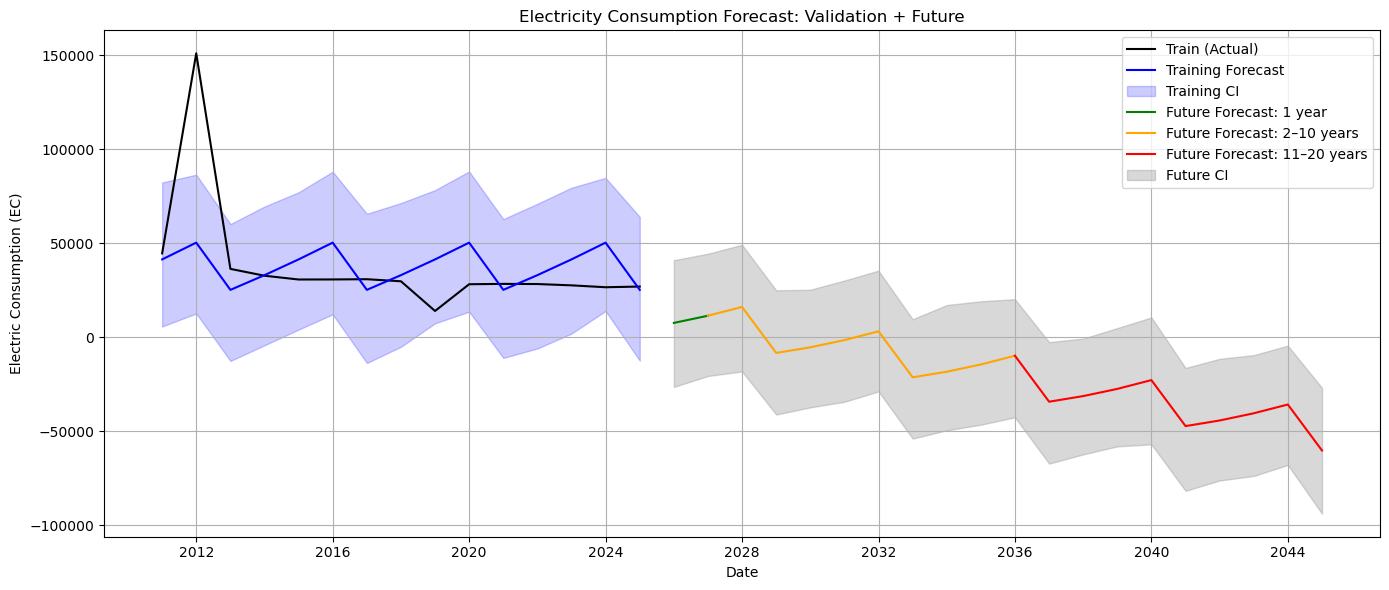

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -26427.765677  40965.942389
1  2026-12-31  11435.971813 -20631.421514  44419.002737
2  2027-12-31  16107.946362 -18203.453656  49163.802865
3  2028-12-31  -8352.617024 -41113.454530  24958.523443
4  2029-12-31  -5369.011127 -37324.260302  25253.470349
5  2030-12-31  -1536.945673 -34363.043871  30151.222885
6  2031-12-31   3135.028876 -28840.943992  35397.791909
7  2032-12-31 -21325.534510 -53913.741555   9562.584309
8  2033-12-31 -18341.928614 -49529.120241  17120.869655
9  2034-12-31 -14509.863160 -46535.816668  19121.422020
10 2035-12-31  -9837.888610 -42597.015886  20222.987297
11 2036-12-31 -34298.451997 -67216.979647  -2614.617430
12 2037-12-31 -31314.846100 -62312.276614   -719.427944
13 2038-12-31 -27482.780646 -58069.356403   4855.103881
14 2039-12-31 -22810.806097 -56993.783014  10535.141772
15 2040-12-31 -47271.369483 -81717.105257 -16341.765426
16 2041-12-31 -44287.763586 -76202.042760 -11478.576772
17 2042-12-31 -40455.698132 -73795.384464  -9525.733825
18 2043-12-31 -35783.723583 -67943.601324  -4493.826759
19 2044-12-31 -60244.286969 -93866.435767 -26913.897318

In [60]:
growth_list = ['logistic', 'linear', 'flat']

for g in growth_list:
    
    prophet_params = {
        'growth': g,
    }

    if g == 'logistic':
        df_yearly_growth = df_yearly.copy()
        df_yearly_growth['cap'] = 55000

    else:
        df_yearly_growth = df_yearly.copy()
        
    print("===============", g, "=================")
    forecast_yearly, model_yearly = run_forecasting_pipeline(df_yearly_growth, **prophet_params)

#### Conclusion:

### Seasonality
Yearly data only has one data point per year — so there’s no way to detect within-year seasonal patterns (like summer vs. winter), which is what yearly seasonality models.

Prophet’s seasonal components (weekly, yearly, etc.) rely on higher-frequency data to learn repeating cycles. With only one observation per year, there is:

* No signal for seasonal cycles,

* Not enough resolution to detect intra-year variation.

Since our data consists only 15 datapoints in a yearly perspective, there is no relavance in tuning yearly seasonality.

### Trend Changepoints

=============== 1 =================
Train range: 2010-12-31 -> 2024-12-31


16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 17016.84
MAPE: 46.98%


16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


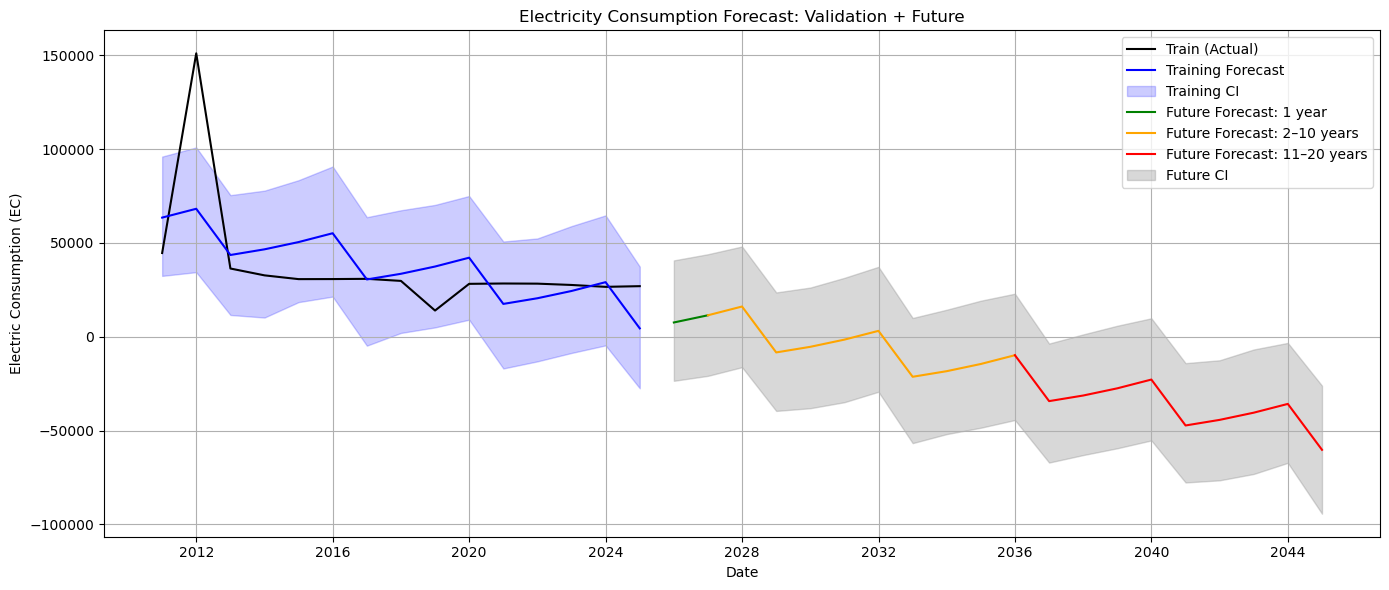

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -23484.960048  40678.439130
1  2026-12-31  11435.971813 -20839.861593  43961.581913
2  2027-12-31  16107.946362 -16221.870864  48078.154283
3  2028-12-31  -8352.617024 -39521.274727  23605.538560
4  2029-12-31  -5369.011127 -38082.387295  26198.262719
5  2030-12-31  -1536.945673 -34885.803525  31372.782495
6  2031-12-31   3135.028876 -29319.453454  37243.063687
7  2032-12-31 -21325.534510 -56678.179222   9992.604671
8  2033-12-31 -18341.928614 -51866.539593  14399.716977
9  2034-12-31 -14509.863160 -48474.570940  19204.771421
10 2035-12-31  -9837.888610 -44371.776213  22934.731733
11 2036-12-31 -34298.451997 -67035.202337  -3630.382939
12 2037-12-31 -31314.846100 -63043.132534   1235.740979
13 2038-12-31 -27482.780646 -59417.166082   5853.605137
14 2039-12-31 -22810.806097 -55244.824088   9819.801488
15 2040-12-31 -47271.369483 -77642.405726 -14071.979972
16 2041-12-31 -44287.763586 -76498.953331 -12531.193110
17 2042-12-31 -40455.698132 -73110.364363  -6792.819496
18 2043-12-31 -35783.723583 -67189.420907  -3283.561321
19 2044-12-31 -60244.286969 -94278.781780 -26069.523811

=============== 3 =================
Train range: 2010-12-31 -> 2024-12-31


16:27:27 - cmdstanpy - INFO - Chain [1] start processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16988.15
MAPE: 46.87%


16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:28 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


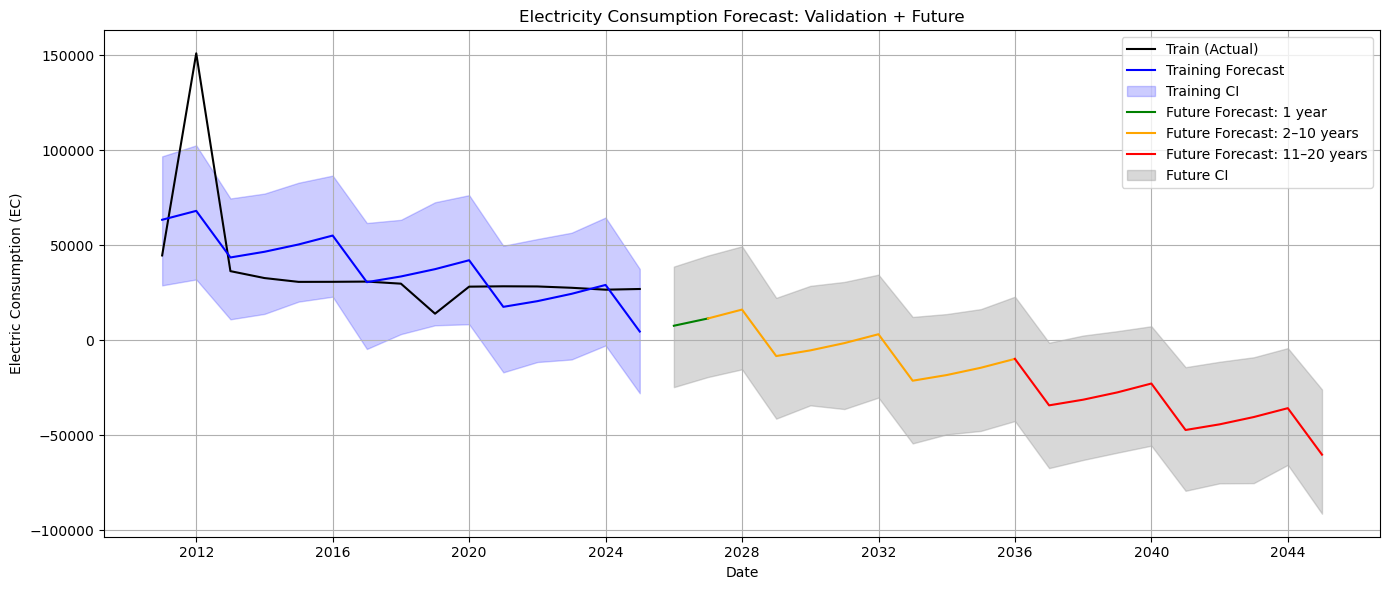

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -24711.860993  38748.269296
1  2026-12-31  11435.971813 -19399.115299  44552.873798
2  2027-12-31  16107.946362 -15339.539963  49412.246186
3  2028-12-31  -8352.617024 -41304.538753  22273.850826
4  2029-12-31  -5369.011127 -34302.771964  28593.524852
5  2030-12-31  -1536.945673 -36252.113651  30670.410383
6  2031-12-31   3135.028876 -30221.072120  34495.027164
7  2032-12-31 -21325.534510 -54331.581281  12230.331014
8  2033-12-31 -18341.928614 -49595.941841  13756.207790
9  2034-12-31 -14509.863160 -47763.708442  16354.759201
10 2035-12-31  -9837.888610 -42553.964720  22890.689228
11 2036-12-31 -34298.451997 -67336.487811  -1332.460853
12 2037-12-31 -31314.846100 -63041.772779   2447.925270
13 2038-12-31 -27482.780646 -59227.287444   4744.082183
14 2039-12-31 -22810.806097 -55531.227975   7340.181552
15 2040-12-31 -47271.369483 -79275.628697 -14209.692853
16 2041-12-31 -44287.763586 -75344.695823 -11360.182176
17 2042-12-31 -40455.698132 -75248.262574  -8998.112518
18 2043-12-31 -35783.723583 -65626.604397  -4174.776358
19 2044-12-31 -60244.286969 -91330.246201 -25932.581015

=============== 5 =================
Train range: 2010-12-31 -> 2024-12-31


16:27:30 - cmdstanpy - INFO - Chain [1] start processing
16:27:30 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16965.62
MAPE: 46.78%


16:27:30 - cmdstanpy - INFO - Chain [1] start processing
16:27:31 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


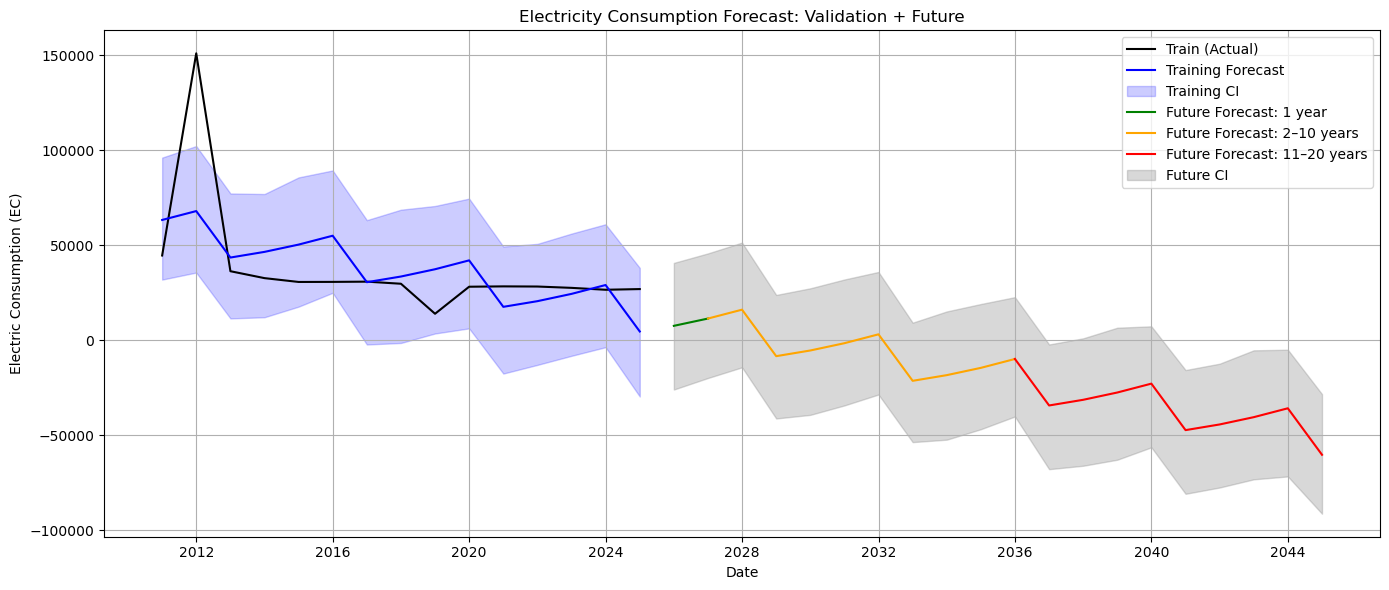

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -25917.636000  40719.219101
1  2026-12-31  11435.971813 -19854.541625  45717.627306
2  2027-12-31  16107.946362 -14229.498725  51399.401239
3  2028-12-31  -8352.617024 -41150.112386  23854.881729
4  2029-12-31  -5369.011127 -39250.643670  27350.188133
5  2030-12-31  -1536.945673 -34287.255125  31977.215528
6  2031-12-31   3135.028876 -28535.905503  35948.931369
7  2032-12-31 -21325.534510 -53588.430516   9261.249394
8  2033-12-31 -18341.928614 -52305.349061  15171.833622
9  2034-12-31 -14509.863160 -46796.501388  19080.533948
10 2035-12-31  -9837.888610 -40091.826721  22694.730436
11 2036-12-31 -34298.451997 -67818.165538  -2203.915646
12 2037-12-31 -31314.846100 -66022.560627   1034.459054
13 2038-12-31 -27482.780646 -62855.994258   6610.342638
14 2039-12-31 -22810.806097 -56322.573822   7344.573680
15 2040-12-31 -47271.369483 -80780.821237 -15661.759897
16 2041-12-31 -44287.763586 -77470.611959 -12315.026417
17 2042-12-31 -40455.698132 -73166.762065  -5278.755068
18 2043-12-31 -35783.723583 -71643.753646  -4961.878642
19 2044-12-31 -60244.286969 -91250.850491 -28322.913680

In [88]:
# n_changepoints
n_changepoints = [1, 3, 5]
prophet_params = {
    'changepoint_range': 1 # training set is spereated from validation set
}
for p in n_changepoints:
    print("===============", p, "=================")
    prophet_params['n_changepoints'] = p
    forecast_yearly, model_yearly = run_forecasting_pipeline(df_yearly, **prophet_params)

    # fig = model_monthly.plot(forecast_monthly)
    # a = add_changepoints_to_plot(fig.gca(), model_monthly, forecast_monthly)

=============== 0.05 =================
Train range: 2010-12-31 -> 2024-12-31


16:28:14 - cmdstanpy - INFO - Chain [1] start processing
16:28:14 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16983.92
MAPE: 46.85%


16:28:15 - cmdstanpy - INFO - Chain [1] start processing
16:28:16 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


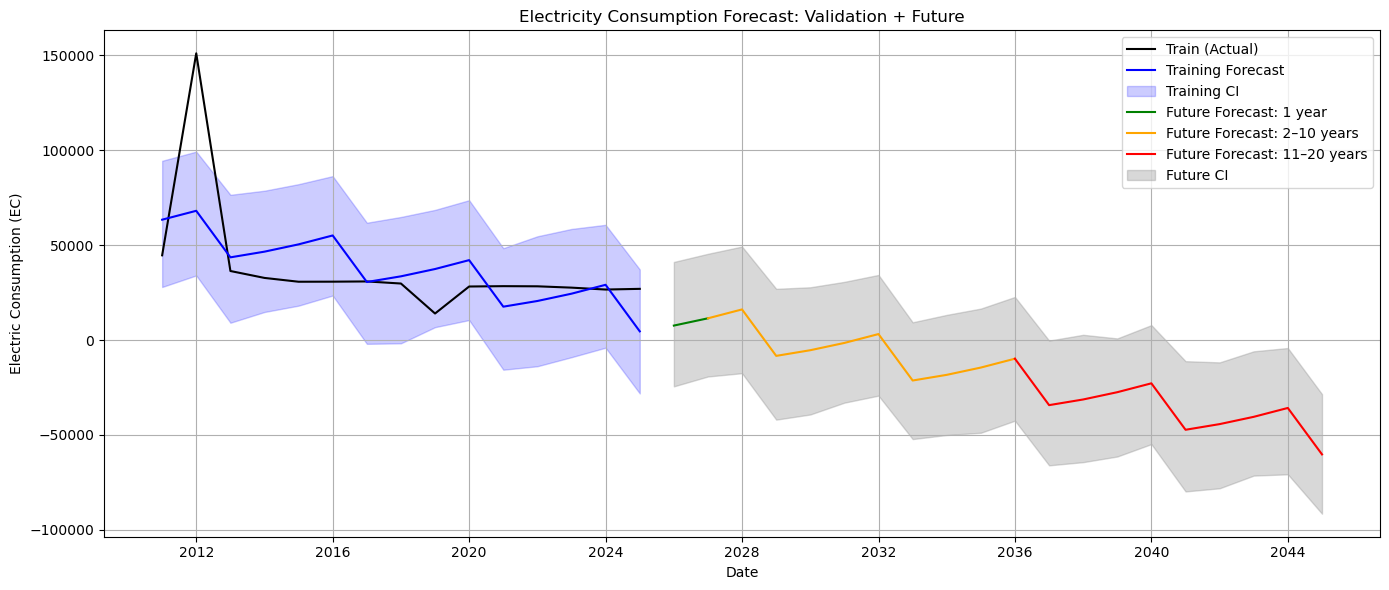

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -24414.907412  41113.186507
1  2026-12-31  11435.971813 -19217.470248  45403.330963
2  2027-12-31  16107.946362 -17475.696231  49224.782255
3  2028-12-31  -8352.617024 -41936.644084  26958.797437
4  2029-12-31  -5369.011127 -39225.505191  27776.435864
5  2030-12-31  -1536.945673 -32999.052626  30633.401323
6  2031-12-31   3135.028876 -29303.395921  34268.121651
7  2032-12-31 -21325.534510 -52175.136956   9335.521787
8  2033-12-31 -18341.928614 -50032.233480  13238.787991
9  2034-12-31 -14509.863160 -48851.698605  16553.174483
10 2035-12-31  -9837.888610 -42481.105063  22675.577114
11 2036-12-31 -34298.451997 -66011.887173   -309.318526
12 2037-12-31 -31314.846100 -64325.401161   2743.703488
13 2038-12-31 -27482.780646 -61360.571527    843.211434
14 2039-12-31 -22810.806097 -54826.281309   7843.549347
15 2040-12-31 -47271.369483 -79752.091217 -11144.158774
16 2041-12-31 -44287.763586 -78090.144051 -11777.057072
17 2042-12-31 -40455.698132 -71413.625726  -5951.365650
18 2043-12-31 -35783.723583 -70727.309013  -4220.681979
19 2044-12-31 -60244.286969 -91478.431250 -28503.559206

=============== 0.01 =================
Train range: 2010-12-31 -> 2024-12-31


16:28:19 - cmdstanpy - INFO - Chain [1] start processing
16:28:19 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3067
MAE: 17251.55
MAPE: 47.92%


16:28:20 - cmdstanpy - INFO - Chain [1] start processing
16:28:21 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


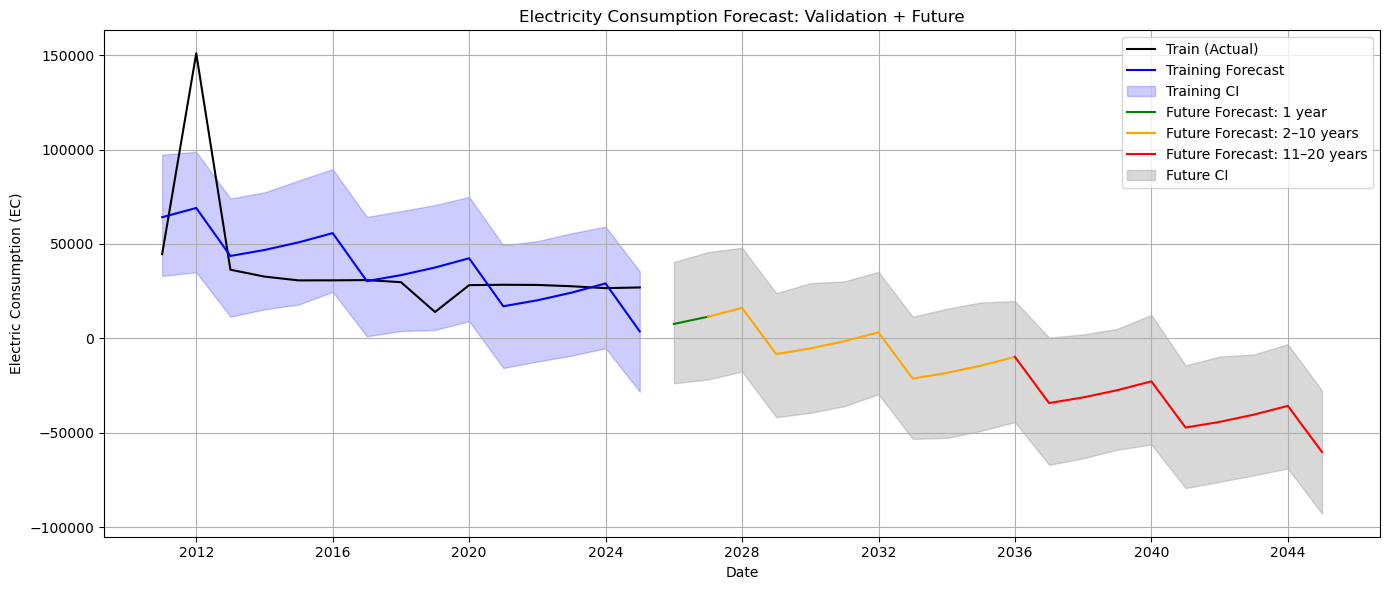

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -23813.391073  40444.253300
1  2026-12-31  11435.971813 -21814.223669  45658.011209
2  2027-12-31  16107.946362 -17598.054999  48017.378849
3  2028-12-31  -8352.617024 -41788.575508  23923.573893
4  2029-12-31  -5369.011127 -39515.137119  29209.244072
5  2030-12-31  -1536.945673 -35944.252872  30167.943781
6  2031-12-31   3135.028876 -29611.596520  35183.060477
7  2032-12-31 -21325.534510 -53285.533684  11438.203520
8  2033-12-31 -18341.928614 -52803.816782  15622.015906
9  2034-12-31 -14509.863160 -49064.705045  19013.558182
10 2035-12-31  -9837.888610 -44403.894694  19718.452859
11 2036-12-31 -34298.451997 -67049.467378    360.774199
12 2037-12-31 -31314.846100 -63564.462331   2078.720507
13 2038-12-31 -27482.780646 -59035.352236   5013.288193
14 2039-12-31 -22810.806097 -56250.633709  12424.700333
15 2040-12-31 -47271.369483 -79370.987021 -14296.076870
16 2041-12-31 -44287.763586 -75986.607611  -9694.282853
17 2042-12-31 -40455.698132 -72622.039000  -8533.126527
18 2043-12-31 -35783.723583 -68946.072561  -3105.951569
19 2044-12-31 -60244.286969 -92918.450521 -27650.389350

=============== 0.025 =================
Train range: 2010-12-31 -> 2024-12-31


16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 17027.28
MAPE: 47.02%


16:28:26 - cmdstanpy - INFO - Chain [1] start processing
16:28:26 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


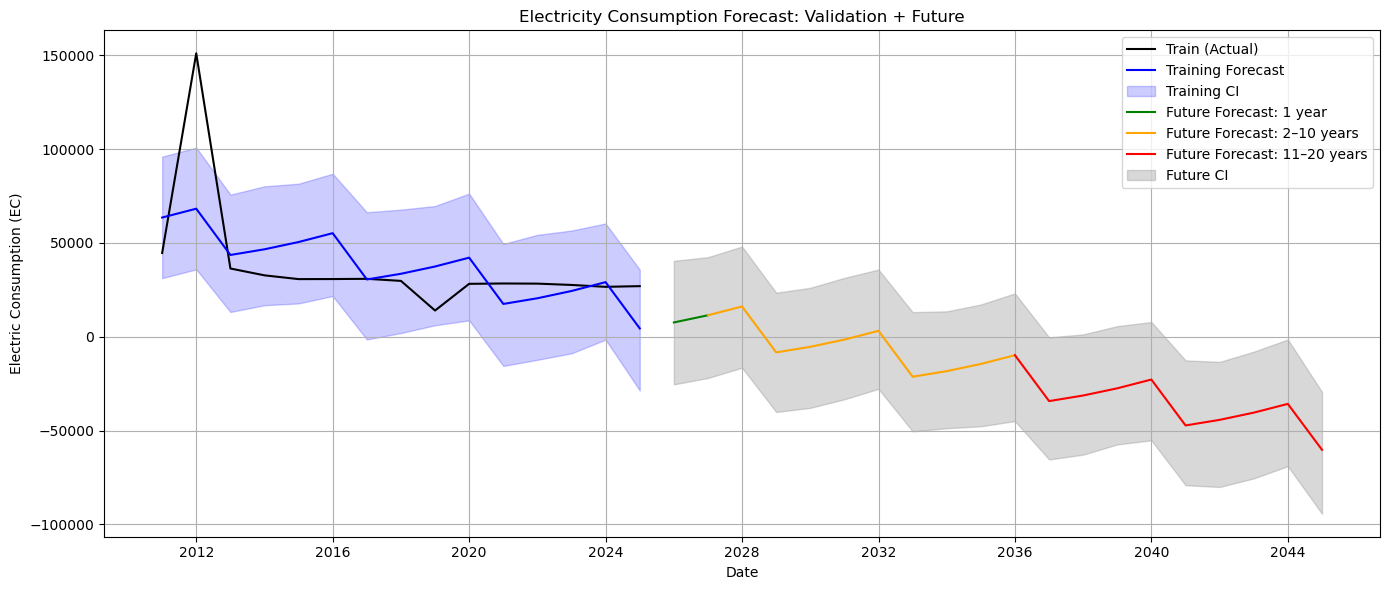

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -25391.335238  40436.526475
1  2026-12-31  11435.971813 -21994.114352  42382.639456
2  2027-12-31  16107.946362 -16525.419596  48035.461856
3  2028-12-31  -8352.617024 -40101.187195  23466.618964
4  2029-12-31  -5369.011127 -37906.037820  26061.476910
5  2030-12-31  -1536.945673 -33342.019765  31350.590507
6  2031-12-31   3135.028876 -27779.293876  35786.689168
7  2032-12-31 -21325.534510 -50409.622528  13092.698128
8  2033-12-31 -18341.928614 -48745.471990  13519.349327
9  2034-12-31 -14509.863160 -47733.829869  17169.354891
10 2035-12-31  -9837.888610 -44943.021957  23086.255992
11 2036-12-31 -34298.451997 -65399.359804   -315.853783
12 2037-12-31 -31314.846100 -62825.779063   1232.661037
13 2038-12-31 -27482.780646 -57379.574742   5646.865261
14 2039-12-31 -22810.806097 -55193.944695   7827.196084
15 2040-12-31 -47271.369483 -79095.319453 -12618.024645
16 2041-12-31 -44287.763586 -80061.734809 -13409.008234
17 2042-12-31 -40455.698132 -75485.464377  -7971.263640
18 2043-12-31 -35783.723583 -68957.581417  -1482.039354
19 2044-12-31 -60244.286969 -94294.189422 -29411.040642

=============== 0.075 =================
Train range: 2010-12-31 -> 2024-12-31


16:28:29 - cmdstanpy - INFO - Chain [1] start processing
16:28:29 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16960.89
MAPE: 46.76%


16:28:30 - cmdstanpy - INFO - Chain [1] start processing
16:28:30 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


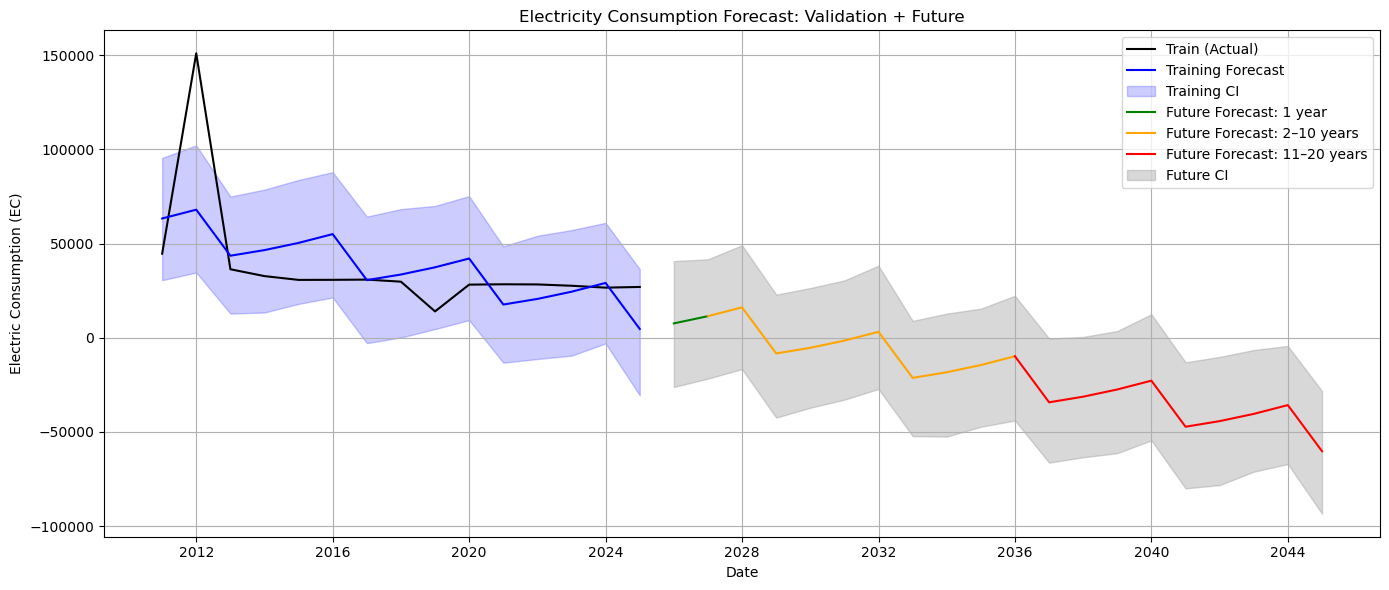

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -26166.644431  40663.168736
1  2026-12-31  11435.971813 -21736.445076  41631.026698
2  2027-12-31  16107.946362 -16670.571644  49123.790552
3  2028-12-31  -8352.617024 -42449.702544  22874.222969
4  2029-12-31  -5369.011127 -37187.192524  26368.865827
5  2030-12-31  -1536.945673 -32895.954997  30425.249983
6  2031-12-31   3135.028876 -27230.874511  38244.797304
7  2032-12-31 -21325.534510 -52263.170360   8934.723789
8  2033-12-31 -18341.928614 -52504.618562  12815.032613
9  2034-12-31 -14509.863160 -47290.551757  15420.496842
10 2035-12-31  -9837.888610 -43967.698310  22271.025738
11 2036-12-31 -34298.451997 -66341.580175   -419.720214
12 2037-12-31 -31314.846100 -63495.601623    410.486707
13 2038-12-31 -27482.780646 -61319.180190   3556.548176
14 2039-12-31 -22810.806097 -54509.957236  12443.595067
15 2040-12-31 -47271.369483 -80016.147894 -13055.381768
16 2041-12-31 -44287.763586 -78265.350609 -10182.642914
17 2042-12-31 -40455.698132 -71149.592307  -6556.927837
18 2043-12-31 -35783.723583 -67077.100047  -4354.732936
19 2044-12-31 -60244.286969 -93447.642760 -28327.239244

=============== 0.1 =================
Train range: 2010-12-31 -> 2024-12-31


16:28:33 - cmdstanpy - INFO - Chain [1] start processing
16:28:33 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16959.74
MAPE: 46.75%


16:28:34 - cmdstanpy - INFO - Chain [1] start processing
16:28:34 - cmdstanpy - INFO - Chain [1] done processing



Future Forecast (from Jan 2025):


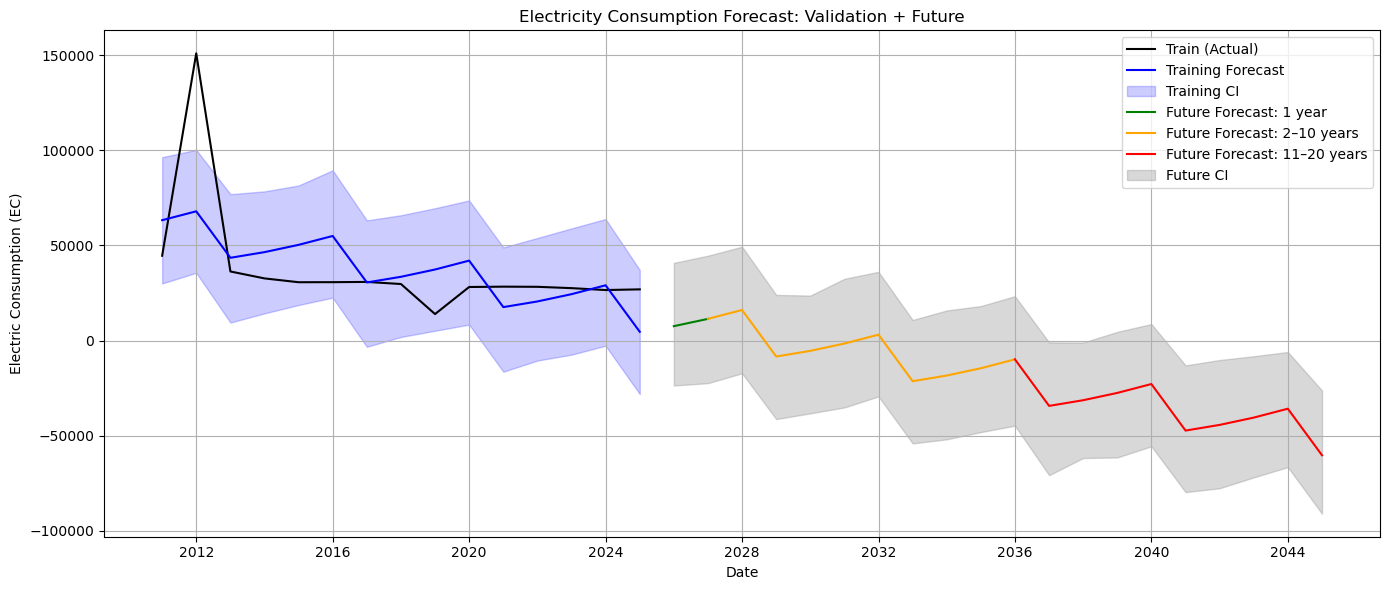

ds          yhat    yhat_lower    yhat_upper
0  2025-12-31   7603.906359 -23577.259879  40873.217750
1  2026-12-31  11435.971813 -22365.098663  44631.877824
2  2027-12-31  16107.946362 -17146.472999  49362.116106
3  2028-12-31  -8352.617024 -41239.291322  24040.650566
4  2029-12-31  -5369.011127 -38228.636217  23672.427591
5  2030-12-31  -1536.945673 -35127.128659  32495.310524
6  2031-12-31   3135.028876 -29330.017384  36153.848692
7  2032-12-31 -21325.534510 -54022.422833  10864.303390
8  2033-12-31 -18341.928614 -51867.409575  15854.522185
9  2034-12-31 -14509.863160 -48078.992701  18180.253606
10 2035-12-31  -9837.888610 -44703.229750  23358.144921
11 2036-12-31 -34298.451997 -70715.380396   -930.004343
12 2037-12-31 -31314.846100 -61691.451244   -992.993260
13 2038-12-31 -27482.780646 -61403.089572   4603.059096
14 2039-12-31 -22810.806097 -55538.361154   8712.298764
15 2040-12-31 -47271.369483 -79623.559778 -13011.195203
16 2041-12-31 -44287.763586 -77584.258748 -10187.556907
17 2042-12-31 -40455.698132 -71873.677375  -8199.434915
18 2043-12-31 -35783.723583 -66480.490608  -5971.967122
19 2044-12-31 -60244.286969 -90960.105728 -26198.718184

In [89]:
# changepoint_prior_scale
changepoint_prior_scale = [0.05, 0.01 ,0.025, 0.075, 0.1]
prophet_params = {
    'changepoint_range': 1 # training set is spereated from validation set
}
for p in changepoint_prior_scale:
    print("===============", p, "=================")
    prophet_params['changepoint_prior_scale'] = p
    forecast_yearly, model_yearly = run_forecasting_pipeline(df_yearly, **prophet_params)